## Data Wrangling and Feature Engineering

The main goal of this section is to clean the data by removing the outliers, duplicate entries and generate new features using various tools. A ready to model dataset will be prepared.

## Importing Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
column_description=pd.read_csv('Original_data/HomeCredit_columns_description.csv', encoding= 'unicode_escape', index_col='Row').drop('Unnamed: 0', axis=1)
column_description.tail()

,Table,Description,Special
Row,,,
NUM_INSTALMENT_NUMBER,installments_payments.csv,On which installment we observe payment,NaN
DAYS_INSTALMENT,installments_payments.csv,When the installment of previous credit was su...,time only relative to the application
DAYS_ENTRY_PAYMENT,installments_payments.csv,When was the installments of previous credit p...,time only relative to the application
AMT_INSTALMENT,installments_payments.csv,What was the prescribed installment amount of ...,NaN
AMT_PAYMENT,installments_payments.csv,What the client actually paid on previous cred...,NaN


In [105]:
column_description.loc['TARGET'][1]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

## 1) Application Train


### 1.1 Data Overview
This is a main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

In [106]:
df=pd.read_csv('Original_data/application_train.csv')
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307499 non-null  float64
 10  AMT_GOODS_PRICE               307233 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nu

***Remarks:***
*   There are total 307,511 rows representing the information of each loans and 120 features. 

*   The response variable:**TARGET** defines if the client had payment difficulties, 1 representing the client had a late payment at least one of the installments of the loan (loan defaulted) and 0 as loan repaid.
*   Many features contains null values, this will be explored in detail later.

### 1.2 Target Variable Distribution

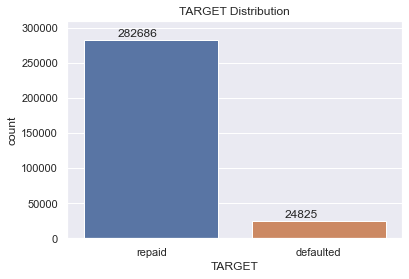

In [107]:
sns.set()
ax=sns.countplot(df['TARGET'])
plt.xticks([1,0],['defaulted', 'repaid'])
plt.ylim([0,310000])
plt.title('TARGET Distribution')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+5000))
        
plt.savefig('target distribution.jpg')


***Data is highly imbalanced.*** There are about 91% loans (about 283K) with target = 0, While only 9% (about 25K) of the total loans indicated having problems in repaying the loan.

### 1.3 Missing Value Analysis

In [108]:
missing_values=pd.DataFrame(df.isnull().sum()*100/len(df)).reset_index()
missing_values.columns=['features','missing_percentage']
missing_values=missing_values[missing_values['missing_percentage']>0].sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_values.tail(10)

,features,missing_percentage
57,NAME_TYPE_SUITE,0.420148
58,DEF_30_CNT_SOCIAL_CIRCLE,0.332021
59,OBS_60_CNT_SOCIAL_CIRCLE,0.332021
60,DEF_60_CNT_SOCIAL_CIRCLE,0.332021
61,OBS_30_CNT_SOCIAL_CIRCLE,0.332021
62,EXT_SOURCE_2,0.214626
63,AMT_GOODS_PRICE,0.090403
64,AMT_ANNUITY,0.003902
65,CNT_FAM_MEMBERS,0.000650
66,DAYS_LAST_PHONE_CHANGE,0.000325


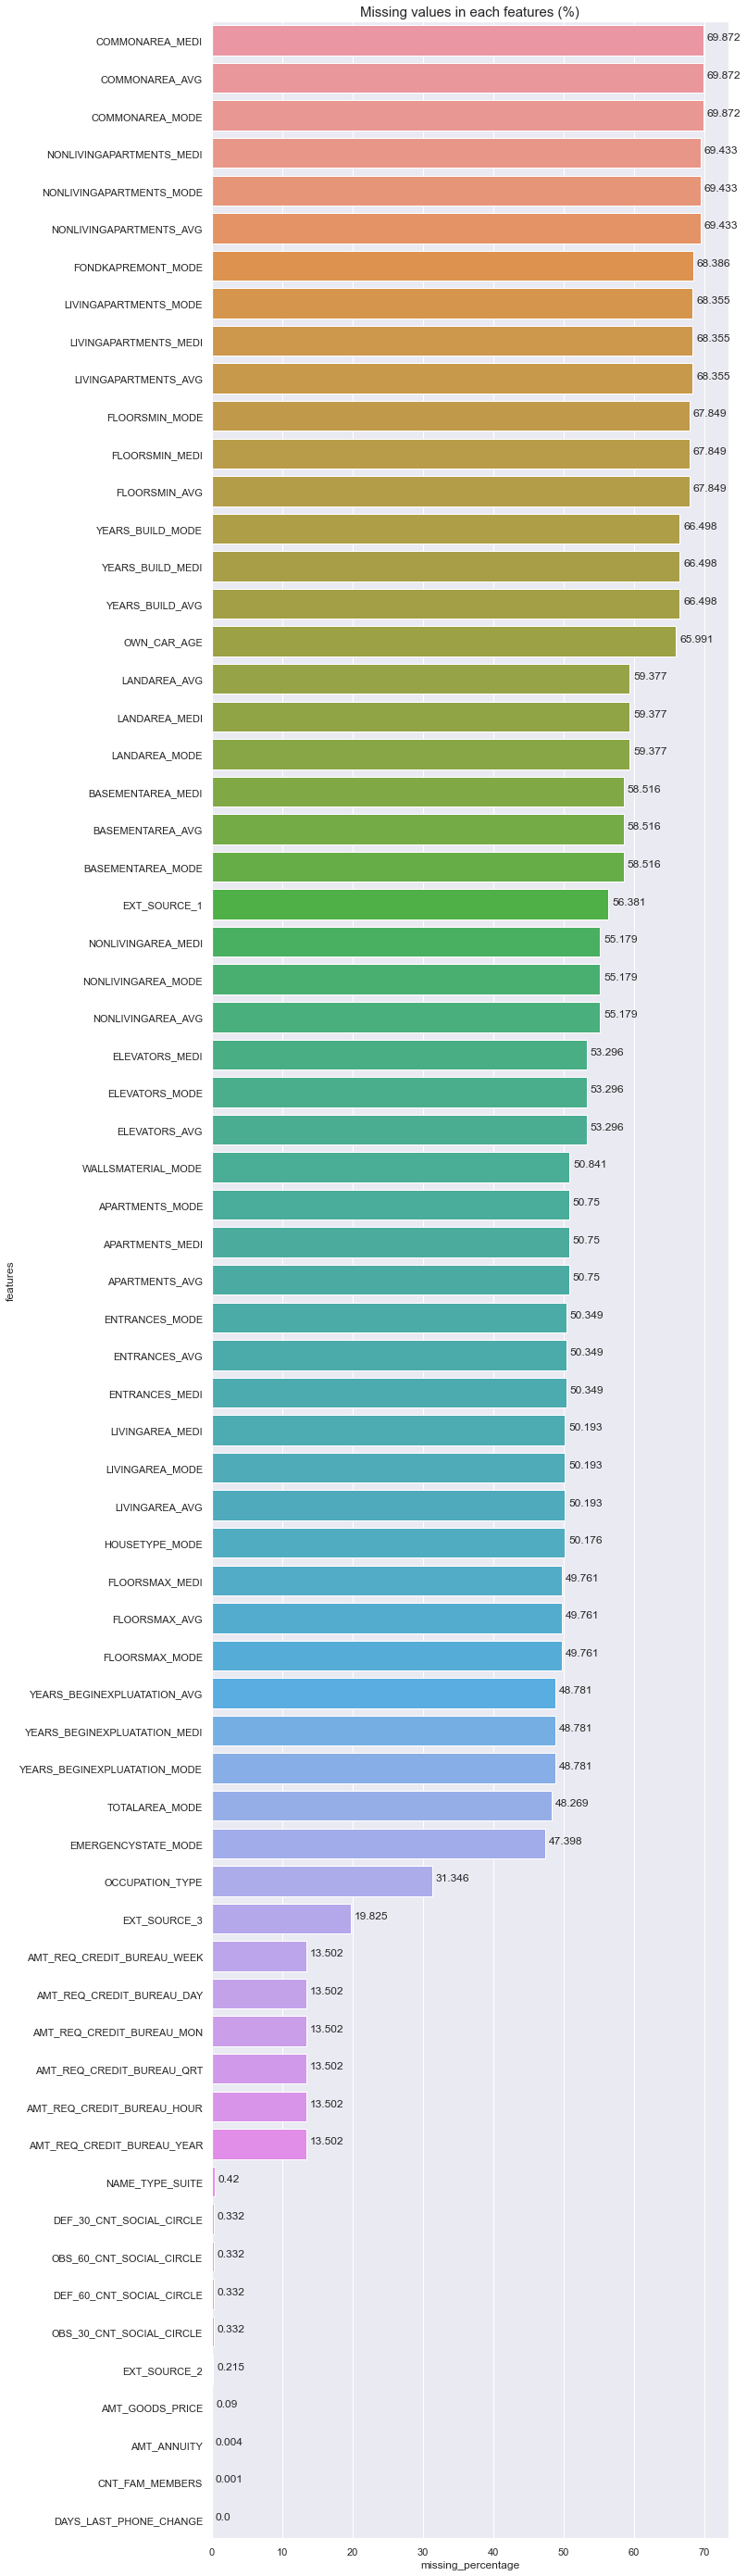

In [109]:
plt.figure(figsize=(10,50))
ax=sns.barplot(y="features", x="missing_percentage", data=missing_values, orient='h')
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Missing values in each features (%)', fontsize=15)

***Remarks***
*   66 features have missing values.
*   40 features have more than 50% missing values and 9 features less than 1%.
*   Features having the information of the building where the applicant lives: Commonarea_med, commonarea_Avg and Commonarea_Mode contains high fraction of missing values about 70%.
*    similarly, Avg, Med and Mode Features describing the building where the client lives are missing in high fraction.

### 1.4 Look at Individual columns to explore and clean the data

#### Features: Categorical

In [110]:
df.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [111]:
cat_1=df.select_dtypes('object').columns.to_list()
cat_1

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

##### Loan Type of the applicants


In [112]:
df['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

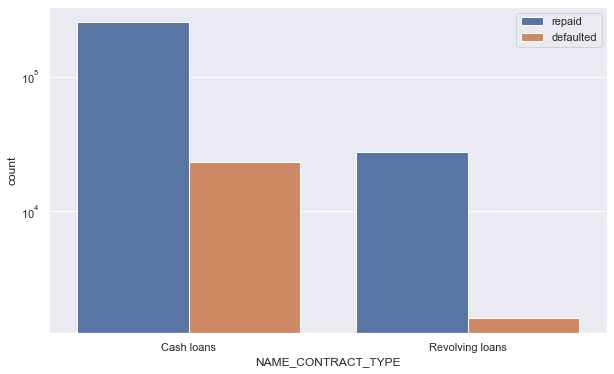

In [113]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')

##### Gender of the applicants

In [114]:
df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

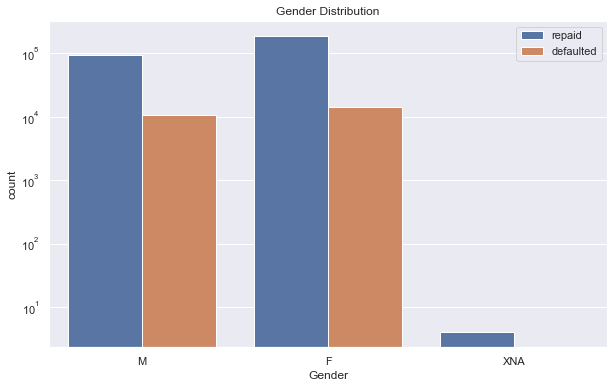

In [115]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='CODE_GENDER', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xlabel('Gender')
plt.savefig('missing values.jpg')
_=plt.title('Gender Distribution')
plt.savefig('gender.jpg')

Majority of the applicants are female. There are very few (4) applicants which identified themselves as neither male nor female. These entries will be dropped.

In [116]:
df=df[df['CODE_GENDER']!='XNA']

##### Whether own a car and Realty

In [117]:
df['FLAG_OWN_CAR'].value_counts()

N    202922
Y    104585
Name: FLAG_OWN_CAR, dtype: int64

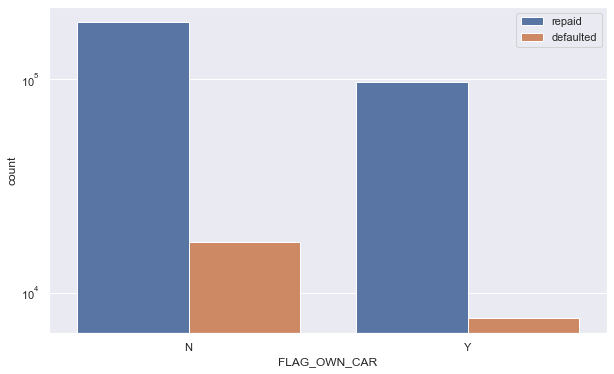

In [118]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')

In [119]:
df['FLAG_OWN_REALTY'].value_counts()

Y    213308
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

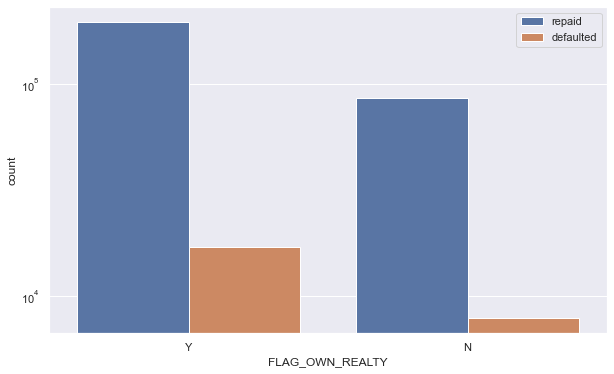

In [120]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')

Majority of the applicants own realty and do not own a car. Same applies for the loan repaid applicants. 

##### Who Accompanied applicants when loan was applied

In [121]:
df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248523
Family              40148
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

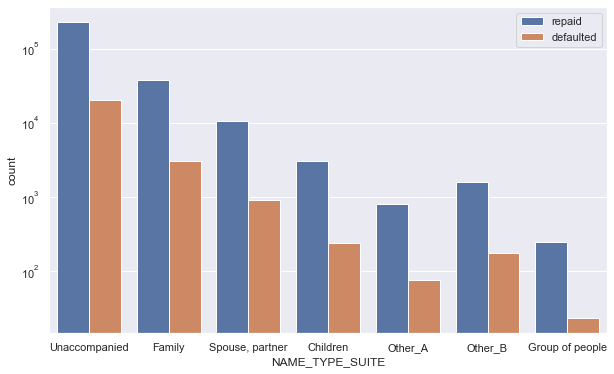

In [122]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')

Most of the applicants were alone when loan was applied. Others_A and Othes_B can be combined as Other.

In [123]:
df['NAME_TYPE_SUITE']=df['NAME_TYPE_SUITE'].replace({'Other_A':'Other', 'Other_B':'Other'})
df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248523
Family              40148
Spouse, partner     11370
Children             3267
Other                2636
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

##### Income Type

In [124]:
df['NAME_INCOME_TYPE'].value_counts()

Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

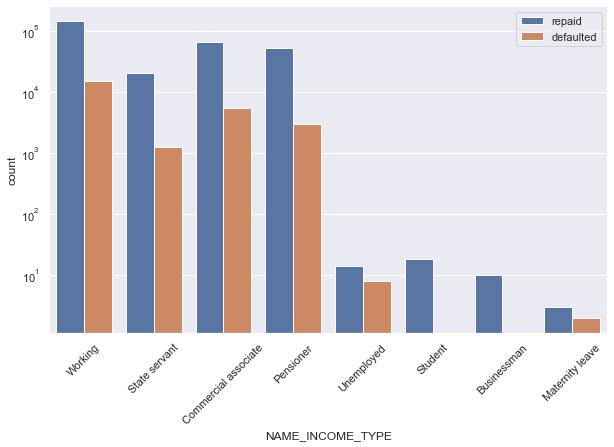

In [125]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

The student and businessman applicants were less in number, however, all of them repaid the loan. 

##### Education of the applicant

In [126]:
df['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218389
Higher education                  74862
Incomplete higher                 10276
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [127]:
df['NAME_EDUCATION_TYPE']=df['NAME_EDUCATION_TYPE'].replace('Secondary / secondary special', 'Secondary')
df['NAME_EDUCATION_TYPE'].value_counts()

Secondary            218389
Higher education      74862
Incomplete higher     10276
Lower secondary        3816
Academic degree         164
Name: NAME_EDUCATION_TYPE, dtype: int64

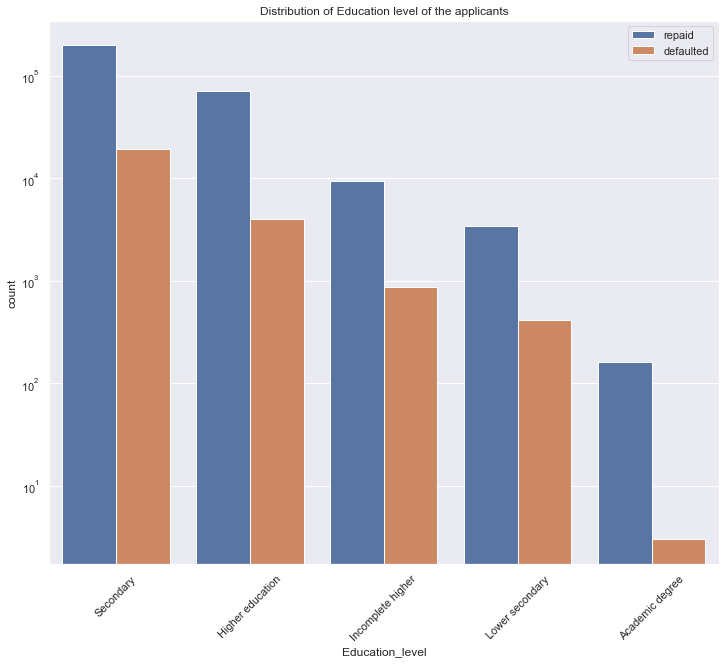

In [128]:
plt.figure(figsize=(12,10))
_=sns.set()
_=sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

_=plt.xlabel('Education_level')
_=plt.title('Distribution of Education level of the applicants')
plt.savefig('education.jpg')

Applicants having an academic degree has higher rate of loan repayment than others.

##### Family Status

In [129]:
df['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

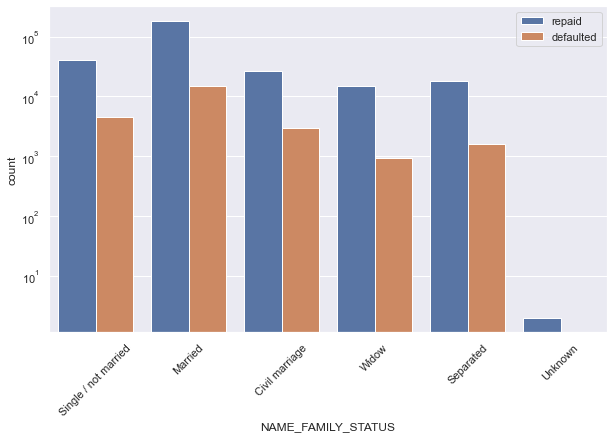

In [130]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

Just two applicants identified as unknown. These entities
can be dropped.

In [131]:
df=df[df['NAME_FAMILY_STATUS']!='Unknown']

##### Housing Type

In [132]:
df['NAME_HOUSING_TYPE'].value_counts()

House / apartment      272864
With parents            14840
Municipal apartment     11181
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

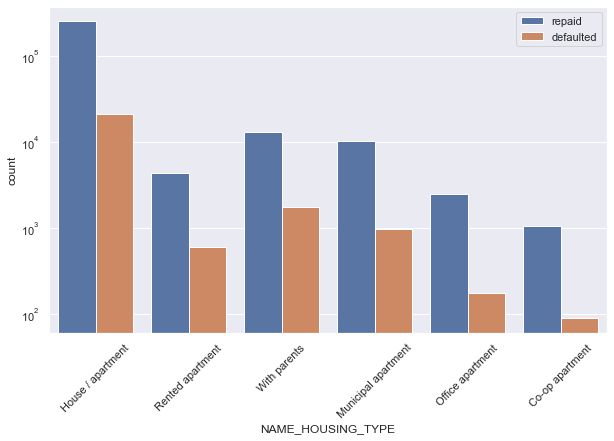

In [133]:
plt.figure(figsize=(10,6))
_=sns.set()
_=sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

Highest hnumber of applicants resides in house/apartment. Applicants with co-op apartment has higher rate of loan repayment.

##### Occupation Type

In [134]:
df['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21370
Drivers                  18603
High skill tech staff    11380
Accountants               9812
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

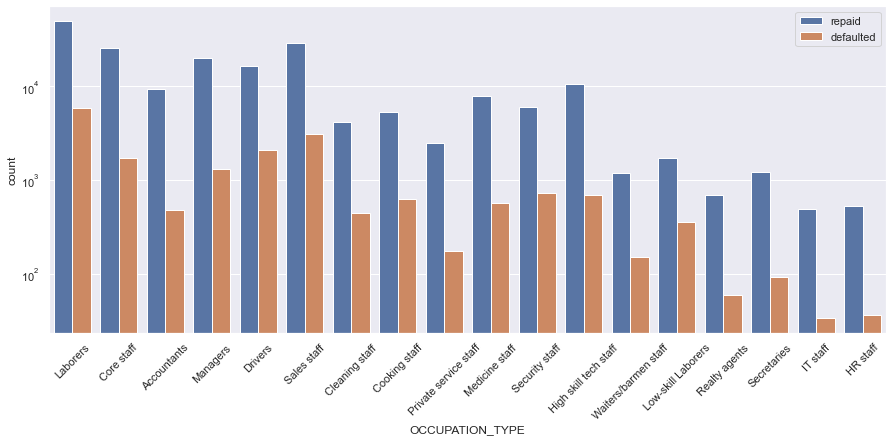

In [135]:
plt.figure(figsize=(15,6))
_=sns.set()
_=sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

##### Application start day

In [136]:
df['WEEKDAY_APPR_PROCESS_START'].value_counts()

TUESDAY      53900
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50589
FRIDAY       50335
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

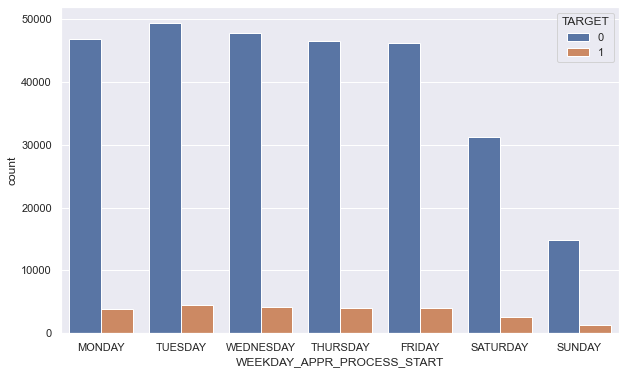

In [137]:
order=['MONDAY', 'TUESDAY', 'WEDNESDAY','THURSDAY', 'FRIDAY', 'SATURDAY','SUNDAY']
plt.figure(figsize=(10,6))
sns.countplot(x='WEEKDAY_APPR_PROCESS_START',hue='TARGET', data=df, order=order)

##### Other categorical Features
Organization type, FONDKAPREMONT mode, housetype mode, Wallsmaterial mode 

In [138]:
df['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [139]:
df['FONDKAPREMONT_MODE'].value_counts()

reg oper account         73828
reg oper spec account    12079
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [140]:
df['HOUSETYPE_MODE'].value_counts()

block of flats      150499
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [141]:
df['WALLSMATERIAL_MODE'].value_counts()

Panel           66038
Stone, brick    64813
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [142]:
df['EMERGENCYSTATE_MODE'].value_counts()

No     159424
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

This is a binary data.

#### Features: Numerical

##### Children count

In [143]:
df['CNT_CHILDREN'].value_counts()

0     215367
1      61118
2      26748
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

In [144]:
# Children count more than 7 are categorised as >7.
counts=df['CNT_CHILDREN'].value_counts()
mask = df['CNT_CHILDREN'].isin(counts[counts < 7].index)
df['CNT_CHILDREN'][mask] ='>7'
df['CNT_CHILDREN'].value_counts()

0     215367
1      61118
2      26748
3       3717
4        429
5         84
6         21
>7        14
7          7
Name: CNT_CHILDREN, dtype: int64

In [145]:
# Converting datatype
df['CNT_CHILDREN']=df['CNT_CHILDREN'].astype('object')

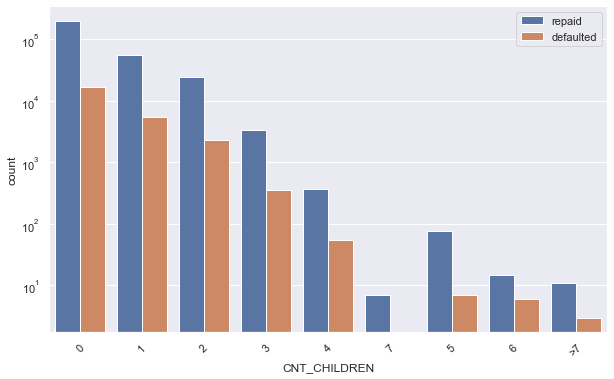

In [146]:
plt.figure(figsize=(10,6))
plot=sns.set()
plot=sns.countplot(x='CNT_CHILDREN', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

##### Family member count


In [147]:
df['CNT_FAM_MEMBERS'].value_counts()

2.0     158355
1.0      67847
3.0      52600
4.0      24696
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
16.0         2
12.0         2
20.0         2
11.0         1
13.0         1
15.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [148]:
# Family member more than 10 are categorised as >10.
counts=df['CNT_FAM_MEMBERS'].value_counts()
mask = df['CNT_FAM_MEMBERS'].isin(counts[counts < 3].index)
df['CNT_FAM_MEMBERS'][mask] ='>10'
df['CNT_FAM_MEMBERS'].value_counts()

2.0     158355
1.0      67847
3.0      52600
4.0      24696
5.0       3478
6.0        408
7.0         81
8.0         20
>10         11
9.0          6
10.0         3
Name: CNT_FAM_MEMBERS, dtype: int64

In [149]:
df['CNT_FAM_MEMBERS']=df['CNT_FAM_MEMBERS'].astype('object')

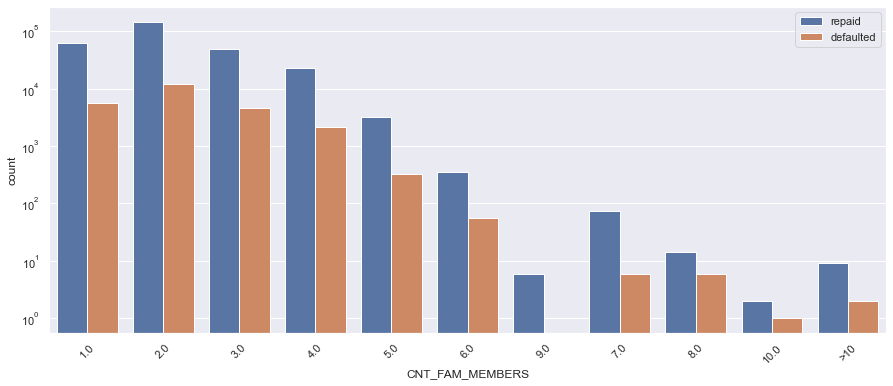

In [150]:
plt.figure(figsize=(15,6))
plot=sns.set()
plot=sns.countplot(x='CNT_FAM_MEMBERS', hue='TARGET', data=df)
plt.legend(loc='upper right', labels=['repaid', 'defaulted'])
plt.yscale('log')
_=plt.xticks(rotation=45)

##### Amount (Income, Credit, Annuity and Goods_Price)

In [151]:
df[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307505.0,168796.661716,237124.848430,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307505.0,599028.395296,402493.886647,45000.0,270000.0,513531.0,808650.0,4050000.0
AMT_ANNUITY,307493.0,27108.638224,14493.840051,1615.5,16524.0,24903.0,34596.0,258025.5
AMT_GOODS_PRICE,307229.0,538397.724489,369447.246462,40500.0,238500.0,450000.0,679500.0,4050000.0


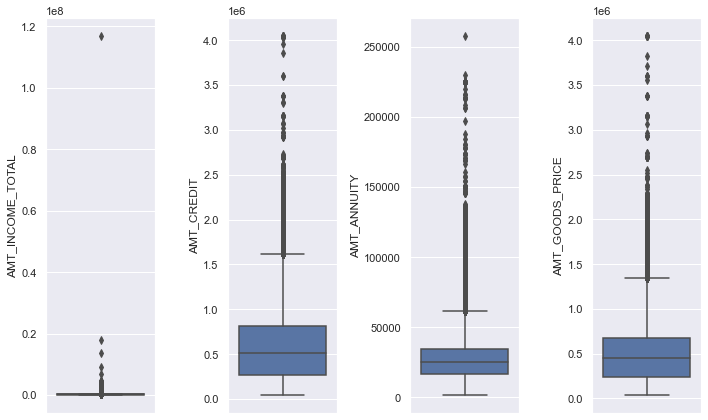

In [152]:
f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (10,6))
sns.boxplot(y='AMT_INCOME_TOTAL', data=df, ax=ax1)
sns.boxplot(y='AMT_CREDIT', data=df, ax=ax2)
sns.boxplot(y='AMT_ANNUITY', data=df, ax=ax3)
sns.boxplot(y='AMT_GOODS_PRICE', data=df, ax=ax4)

plt.tight_layout()

There are many outliers in the features. The Max value of Amount incorme total seems like an error. This should be dropped.

In [153]:
df=df[df['AMT_INCOME_TOTAL']<1e8]

In [154]:
df[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].isnull().sum()

AMT_INCOME_TOTAL      0
AMT_CREDIT            0
AMT_ANNUITY          12
AMT_GOODS_PRICE     276
dtype: int64

The missing values are few, let's drop the applicants with null values

In [155]:
df=df.dropna(subset=['AMT_GOODS_PRICE','AMT_ANNUITY'])

##### Relative Population Region

In [156]:
df['REGION_POPULATION_RELATIVE'].isnull().sum()

0

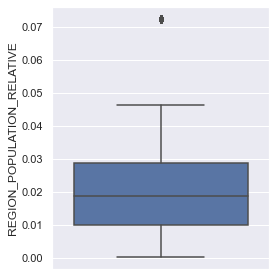

In [157]:
plt.figure(figsize=(4,4))
sns.boxplot(y='REGION_POPULATION_RELATIVE', data=df)
plt.tight_layout()

In [158]:
df['REGION_POPULATION_RELATIVE'].sort_values(ascending=False)

182366    0.072508
74280     0.072508
74231     0.072508
100441    0.072508
100430    0.072508
            ...   
96885     0.000533
190149    0.000533
21965     0.000533
248609    0.000290
280258    0.000290
Name: REGION_POPULATION_RELATIVE, Length: 307216, dtype: float64

In [159]:
len(df[df['REGION_POPULATION_RELATIVE']==0.072508])

8407

There are numerous entries with 0.072508. Hence, this is not a good idea to drop all those entries.

##### Ages and duration of employment 

In [160]:
df[['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE']]

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE
0,-9461,-637,-3648.0,-2120,NaN
1,-16765,-1188,-1186.0,-291,NaN
2,-19046,-225,-4260.0,-2531,26.0
3,-19005,-3039,-9833.0,-2437,NaN
4,-19932,-3038,-4311.0,-3458,NaN
...,...,...,...,...,...
307506,-9327,-236,-8456.0,-1982,NaN
307507,-20775,365243,-4388.0,-4090,NaN
307508,-14966,-7921,-6737.0,-5150,NaN
307509,-11961,-4786,-2562.0,-931,NaN


Let's change these negative values into positive.

In [161]:
df[['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH','OWN_CAR_AGE']]=df[['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH','OWN_CAR_AGE']].apply(lambda x:abs(x))

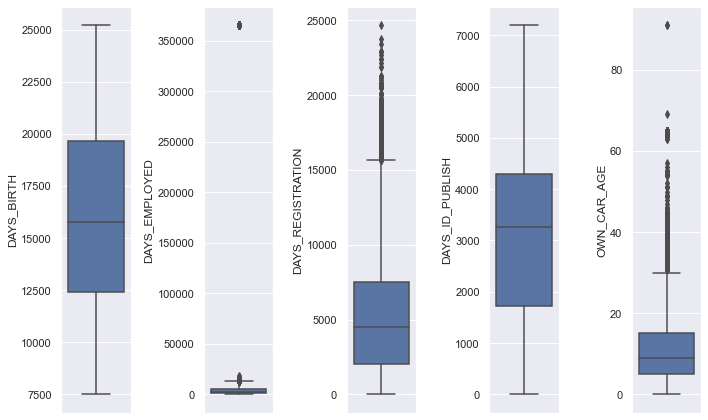

In [162]:
f,(ax1,ax2,ax3,ax4, ax5) = plt.subplots(1,5, figsize = (10,6))
sns.boxplot(y='DAYS_BIRTH', data=df, ax=ax1)
sns.boxplot(y='DAYS_EMPLOYED', data=df, ax=ax2)
sns.boxplot(y='DAYS_REGISTRATION', data=df, ax=ax3)
sns.boxplot(y='DAYS_ID_PUBLISH', data=df, ax=ax4)
sns.boxplot(y='OWN_CAR_AGE', data=df, ax=ax5)

plt.tight_layout()

There are outliers in the features. Some extreme outliers like Days employed more than 350000 seems like an error in during data entry. 
Let's replace this by 0.


In [163]:
df['DAYS_EMPLOYED'].value_counts()

365243    55352
200         156
224         152
230         151
199         151
          ...  
10128         1
13140         1
12322         1
15568         1
8217          1
Name: DAYS_EMPLOYED, Length: 12572, dtype: int64

In [164]:
df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].replace(365243,0)

In [165]:
# checking null values
df[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].isnull().sum()/len(df)

DAYS_BIRTH           0.0
DAYS_EMPLOYED        0.0
DAYS_REGISTRATION    0.0
DAYS_ID_PUBLISH      0.0
dtype: float64

In [166]:
df[['OWN_CAR_AGE']].isnull().sum()/len(df)

OWN_CAR_AGE    0.659598
dtype: float64

There are large number of missing values for the Age to own a car.

##### Flag_ features

In [167]:
df[['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']].nunique()

FLAG_MOBIL          2
FLAG_EMP_PHONE      2
FLAG_WORK_PHONE     2
FLAG_CONT_MOBILE    2
FLAG_PHONE          2
FLAG_EMAIL          2
dtype: int64

These features are binary. Let's convert these into object.

In [168]:
df[['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL']]=df[['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL']].astype('object')

In [169]:
df[['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL']].isnull().sum()

FLAG_MOBIL          0
FLAG_EMP_PHONE      0
FLAG_WORK_PHONE     0
FLAG_CONT_MOBILE    0
FLAG_PHONE          0
FLAG_EMAIL          0
dtype: int64

##### Region _Features


In [170]:
df[['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']].nunique()

REGION_RATING_CLIENT           3
REGION_RATING_CLIENT_W_CITY    3
REG_REGION_NOT_LIVE_REGION     2
REG_REGION_NOT_WORK_REGION     2
LIVE_REGION_NOT_WORK_REGION    2
REG_CITY_NOT_LIVE_CITY         2
REG_CITY_NOT_WORK_CITY         2
LIVE_CITY_NOT_WORK_CITY        2
dtype: int64

In [171]:
df[['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY' ]].isnull().sum()

REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
dtype: int64

These features are categorical with numerical values. Let's convert those into object.

In [172]:
df[['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY' ]]=df[['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY' ]].astype('object')

##### Time of application start

In [173]:
df['HOUR_APPR_PROCESS_START'].value_counts()

10    37691
11    37190
12    34196
13    30924
14    27659
9     27366
15    24813
16    20361
8     15110
17    14882
7      9126
18     9041
6      5837
19     3845
5      3638
4      2089
3      1229
20     1192
21      405
2       305
22      150
1        86
23       41
0        40
Name: HOUR_APPR_PROCESS_START, dtype: int64

This needs to be converted into categorical feature.

In [174]:
df['HOUR_APPR_PROCESS_START']=df['HOUR_APPR_PROCESS_START'].astype(object)

##### External_sources

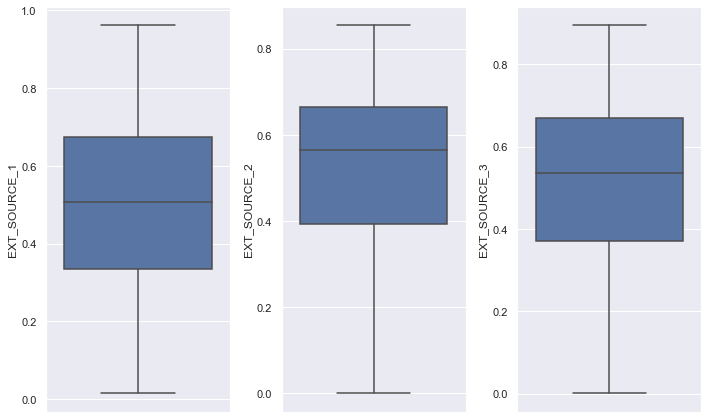

In [175]:
f,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (10,6))
sns.boxplot(y='EXT_SOURCE_1', data=df, ax=ax1)
sns.boxplot(y='EXT_SOURCE_2', data=df, ax=ax2)
sns.boxplot(y='EXT_SOURCE_3', data=df, ax=ax3)

plt.tight_layout()

In [176]:
df[['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']].isnull().sum()/len(df)

EXT_SOURCE_1    0.563864
EXT_SOURCE_2    0.002145
EXT_SOURCE_3    0.198219
dtype: float64

##### Flag_documents

In [177]:
df[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']].nunique()

FLAG_DOCUMENT_2     2
FLAG_DOCUMENT_3     2
FLAG_DOCUMENT_4     2
FLAG_DOCUMENT_5     2
FLAG_DOCUMENT_6     2
FLAG_DOCUMENT_7     2
FLAG_DOCUMENT_8     2
FLAG_DOCUMENT_9     2
FLAG_DOCUMENT_10    2
FLAG_DOCUMENT_11    2
FLAG_DOCUMENT_12    2
FLAG_DOCUMENT_13    2
FLAG_DOCUMENT_14    2
FLAG_DOCUMENT_15    2
FLAG_DOCUMENT_16    2
FLAG_DOCUMENT_17    2
FLAG_DOCUMENT_18    2
FLAG_DOCUMENT_19    2
FLAG_DOCUMENT_20    2
FLAG_DOCUMENT_21    2
dtype: int64

These are binary features. Let's convert these into categorical features.

In [178]:
df[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]=df[['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']].astype('object')

##### Number of Credit Bureau Enquiries

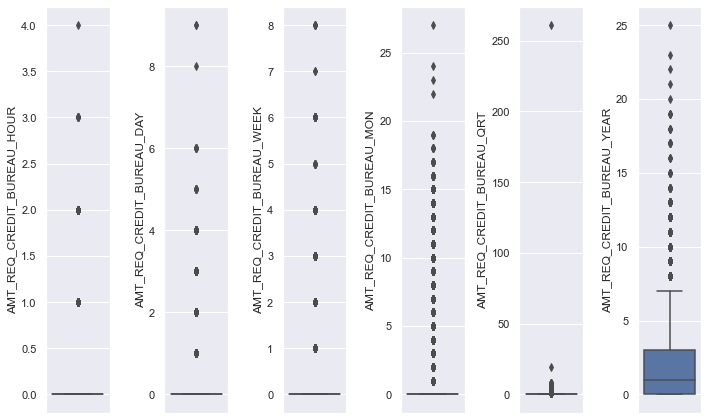

In [179]:
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize = (10,6))
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_HOUR', data=df, ax=ax1)
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_DAY', data=df, ax=ax2)
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_WEEK', data=df, ax=ax3)
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_MON', data=df, ax=ax4)
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_QRT', data=df, ax=ax5)
sns.boxplot(y='AMT_REQ_CREDIT_BUREAU_YEAR', data=df, ax=ax6)

plt.tight_layout()

There are many outliers, but all values looks legit.

##### Client's social surroundings with observable 30 DPD (days past due) default

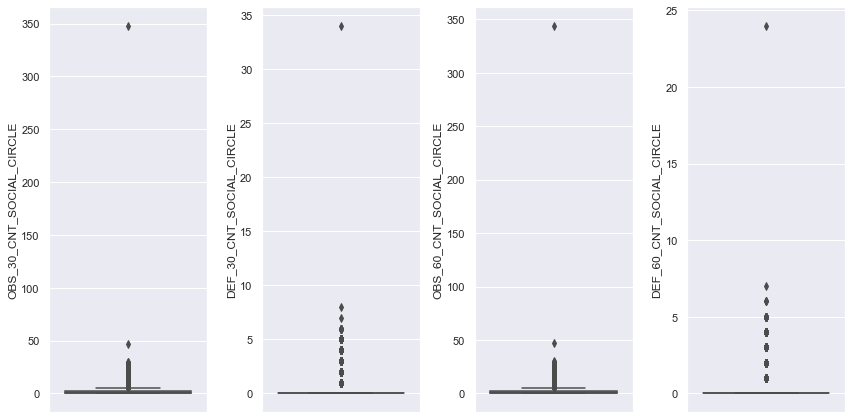

In [180]:
f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (12,6))
sns.boxplot(y='OBS_30_CNT_SOCIAL_CIRCLE', data=df, ax=ax1)
sns.boxplot(y='DEF_30_CNT_SOCIAL_CIRCLE', data=df, ax=ax2)
sns.boxplot(y='OBS_60_CNT_SOCIAL_CIRCLE', data=df, ax=ax3)
sns.boxplot(y='DEF_60_CNT_SOCIAL_CIRCLE', data=df, ax=ax4)


plt.tight_layout()

There are extreme outliers, however these values looks legit.

##### Last Phone Change

In [181]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts()

 0.0       37658
-1.0        2812
-2.0        2316
-3.0        1763
-4.0        1285
           ...  
-3747.0        1
-3745.0        1
-3850.0        1
-4051.0        1
-3915.0        1
Name: DAYS_LAST_PHONE_CHANGE, Length: 3773, dtype: int64

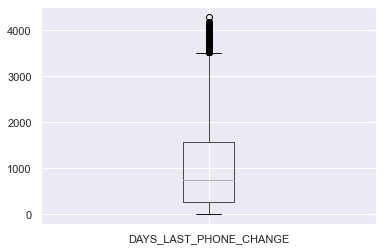

In [182]:
df[['DAYS_LAST_PHONE_CHANGE']]=df[['DAYS_LAST_PHONE_CHANGE']].apply(lambda x:abs(x))
df[['DAYS_LAST_PHONE_CHANGE']].boxplot()

There are outliers, however the values are legit.


##### Average, Median and Mode 

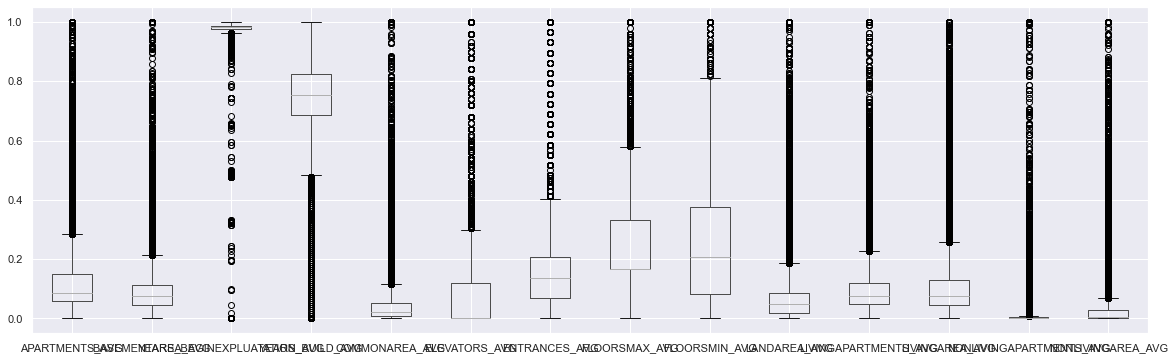

In [183]:
plt.figure(figsize=(20,6))
df[['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']].boxplot()

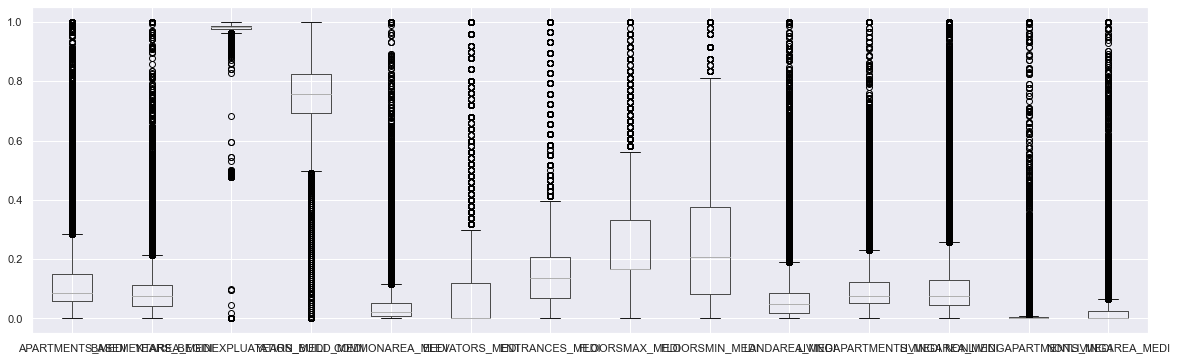

In [184]:
plt.figure(figsize=(20,6))
df[['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']].boxplot()

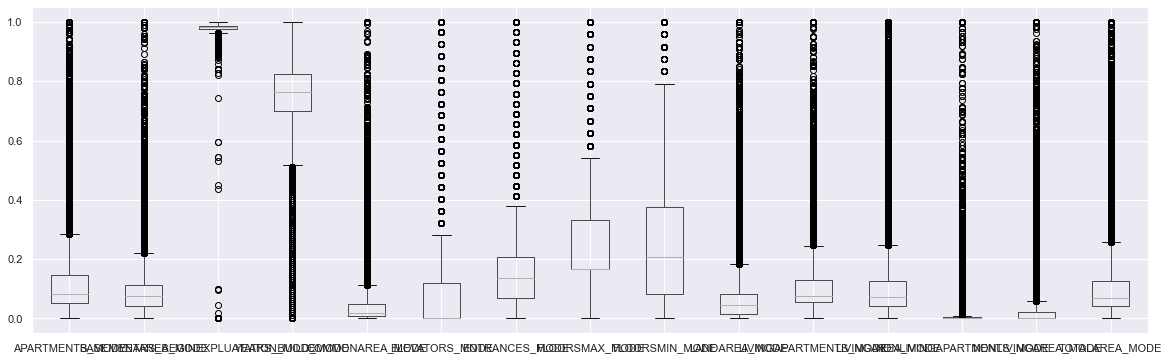

In [185]:
plt.figure(figsize=(20,6))
df[['APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE','TOTALAREA_MODE']].boxplot()

There are outliers, however they all within [0,1]. 

In [192]:
cat_1

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [193]:
# cat_1:categorical features before data engineering
features=df.columns.to_list()
remaining_feat=[feature for feature in features if feature not in cat_1]
# cat_2: categorical features created after feature engineering
cat_2=df[remaining_feat].select_dtypes('object').columns.to_list()
#num_feat: numerical features
num_feat=[feature for feature in remaining_feat if feature not in cat_2]


In [194]:
#checking
len(cat_1)+len(cat_2)+len(num_feat)==len(df.columns)

True

#### Missing Value Imputation

Categorical Features

Cat_1

In [195]:
Missing_counts=pd.DataFrame(df[cat_1].isnull().sum()/len(df)*100).reset_index()
Missing_counts.columns=['Features', 'null_counts(%)']
Missing_counts[Missing_counts['null_counts(%)']>0].reset_index(drop=True)

,Features,null_counts(%)
0,NAME_TYPE_SUITE,0.330061
1,OCCUPATION_TYPE,31.356440
2,FONDKAPREMONT_MODE,68.380228
3,HOUSETYPE_MODE,50.173494
4,WALLSMATERIAL_MODE,50.839149
5,EMERGENCYSTATE_MODE,47.394341


In [196]:
df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248511
Family              40147
Spouse, partner     11370
Children             3267
Other                2636
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [197]:
df['OCCUPATION_TYPE'].value_counts()

Laborers                 55131
Sales staff              32063
Core staff               27529
Managers                 21347
Drivers                  18589
High skill tech staff    11370
Accountants               9801
Medicine staff            8527
Security staff            6712
Cooking staff             5939
Cleaning staff            4648
Private service staff     2648
Low-skill Laborers        2091
Waiters/barmen staff      1346
Secretaries               1304
Realty agents              751
HR staff                   563
IT staff                   525
Name: OCCUPATION_TYPE, dtype: int64

In [198]:
df['FONDKAPREMONT_MODE'].value_counts()

reg oper account         73774
reg oper spec account    12071
not specified             5681
org spec account          5615
Name: FONDKAPREMONT_MODE, dtype: int64

In [199]:
df['HOUSETYPE_MODE'].value_counts()

block of flats      150368
specific housing      1497
terraced house        1210
Name: HOUSETYPE_MODE, dtype: int64

In [200]:
df['WALLSMATERIAL_MODE'].value_counts()

Panel           65992
Stone, brick    64748
Block            9240
Wooden           5353
Mixed            2295
Monolithic       1777
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [201]:
df['EMERGENCYSTATE_MODE'].value_counts()

No     159287
Yes      2326
Name: EMERGENCYSTATE_MODE, dtype: int64

In [202]:
# missing values imputation
df['NAME_TYPE_SUITE'].fillna(value='Unknown', inplace=True)
df['OCCUPATION_TYPE'].fillna(value='Unknown', inplace=True)
df['FONDKAPREMONT_MODE'].fillna(value='not specified',inplace=True)
df['HOUSETYPE_MODE'].fillna(value='Unknown',inplace=True)
df['WALLSMATERIAL_MODE'].fillna(value='Others',inplace=True)
df['EMERGENCYSTATE_MODE'].fillna(value='No',inplace=True)

In [203]:
#Checking if null values are imputed
Missing_counts=pd.DataFrame(df[cat_1].isnull().sum()/len(df)*100).reset_index()
Missing_counts.columns=['Features', 'null_counts(%)']
Missing_counts[Missing_counts['null_counts(%)']>0].reset_index(drop=True)

,Features,null_counts(%)


cat_2

In [204]:
Missing_counts=pd.DataFrame(df[cat_2].isnull().sum()/len(df)*100).reset_index()
Missing_counts.columns=['Features', 'null_counts(%)']
Missing_counts[Missing_counts['null_counts(%)']>0].reset_index(drop=True)

,Features,null_counts(%)


No missing values.

Numerical Features

In [205]:
Missing_counts=pd.DataFrame(df[num_feat].isnull().sum()/len(df)*100).reset_index()
Missing_counts.columns=['Features', 'null_counts(%)']
Missing_counts[Missing_counts['null_counts(%)']>0].reset_index(drop=True)

,Features,null_counts(%)
0,OWN_CAR_AGE,65.959781
1,EXT_SOURCE_1,56.386386
2,EXT_SOURCE_2,0.214507
3,EXT_SOURCE_3,19.821884
4,APARTMENTS_AVG,50.746380
5,BASEMENTAREA_AVG,58.512903
6,YEARS_BEGINEXPLUATATION_AVG,48.778384
7,YEARS_BUILD_AVG,66.491980
8,COMMONAREA_AVG,69.865502
9,ELEVATORS_AVG,53.292146


In [206]:
#splitting df based on Target
df0=df[df['TARGET']==0]
df1=df[df['TARGET']==1]

No handles with labels found to put in legend.


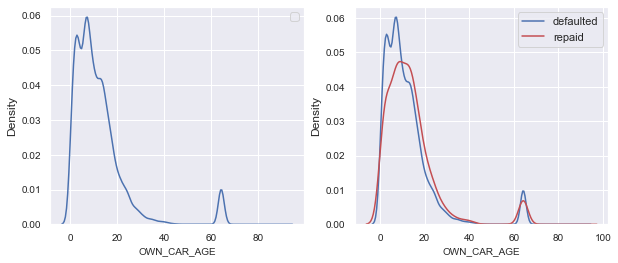

In [207]:
fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(10,4))

sns.kdeplot(df['OWN_CAR_AGE'], ax=ax1)
ax1.tick_params(labelsize=10)
ax1.set_xlabel('OWN_CAR_AGE', size=10)
ax1.legend()


sns.kdeplot(df0['OWN_CAR_AGE'], color='b', Label='defaulted', ax=ax2)
sns.kdeplot(df1['OWN_CAR_AGE'], color='r', Label='repaid', ax=ax2)
ax2.tick_params(labelsize=10)
ax2.set_xlabel('OWN_CAR_AGE', size=10)
ax2.legend()


Missing values in OWN_CAR_AGE might represent the applicants who do not own a car. Hence, lets impute the missing values by 0.


In [208]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull().sum()/len(df)

EXT_SOURCE_1    0.563864
EXT_SOURCE_2    0.002145
EXT_SOURCE_3    0.198219
dtype: float64

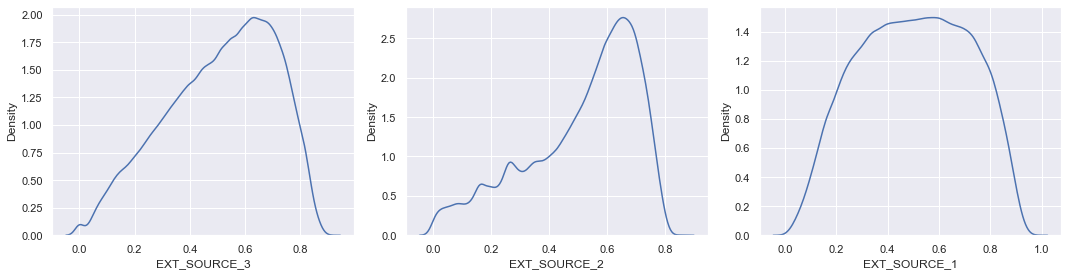

In [209]:
fig,(ax1,ax2,ax3) =plt.subplots(nrows=1,ncols=3,figsize=(15,4))
sns.kdeplot(df['EXT_SOURCE_3'], ax=ax1)
sns.kdeplot(df['EXT_SOURCE_2'], ax=ax2)
sns.kdeplot(df['EXT_SOURCE_1'],ax=ax3)

plt.tight_layout()

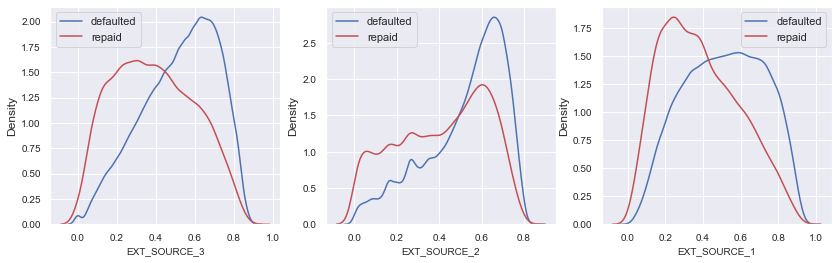

In [210]:
fig,(ax1,ax2,ax3) =plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.kdeplot(df0['EXT_SOURCE_3'], color='b', Label='defaulted', ax=ax1)
sns.kdeplot(df1['EXT_SOURCE_3'], color='r', Label='repaid', ax=ax1)
ax1.tick_params(labelsize=10)
ax1.set_xlabel('EXT_SOURCE_3', size=10)
ax1.legend()



sns.kdeplot(df0['EXT_SOURCE_2'], color='b', Label='defaulted', ax=ax2)
sns.kdeplot(df1['EXT_SOURCE_2'], color='r', Label='repaid', ax=ax2)
ax2.tick_params(labelsize=10)
ax2.set_xlabel('EXT_SOURCE_2', size=10)
ax2.legend()


sns.kdeplot(df0['EXT_SOURCE_1'], color='b', Label='defaulted', ax=ax3)
sns.kdeplot(df1['EXT_SOURCE_1'], color='r', Label='repaid', ax=ax3)
ax3.tick_params(labelsize=10)
ax3.set_xlabel('EXT_SOURCE_1', size=10)
ax3.legend()

Target is clearly distinct for those features. Hence, the missing values should be imputed considering mean of each distribution.


In [211]:
df[['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']].isnull().sum()

AMT_REQ_CREDIT_BUREAU_HOUR    41472
AMT_REQ_CREDIT_BUREAU_DAY     41472
AMT_REQ_CREDIT_BUREAU_WEEK    41472
AMT_REQ_CREDIT_BUREAU_MON     41472
AMT_REQ_CREDIT_BUREAU_QRT     41472
AMT_REQ_CREDIT_BUREAU_YEAR    41472
dtype: int64

The missing values must represent no enquiries. Let's fill the missing values by 0.


In [212]:
df[['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']].isnull().sum()

OBS_30_CNT_SOCIAL_CIRCLE    1021
DEF_30_CNT_SOCIAL_CIRCLE    1021
OBS_60_CNT_SOCIAL_CIRCLE    1021
DEF_60_CNT_SOCIAL_CIRCLE    1021
dtype: int64

The missing values should represent no such default. Let's replace those values by 0.

In [213]:
df[['DAYS_LAST_PHONE_CHANGE']].isnull().sum()

DAYS_LAST_PHONE_CHANGE    1
dtype: int64

The missing value should represent applicant who havent changed phone. Let's fill the missing value by 0.

In [214]:
df[['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']].isnull().sum()/len(df)

APARTMENTS_AVG                 0.507464
BASEMENTAREA_AVG               0.585129
YEARS_BEGINEXPLUATATION_AVG    0.487784
YEARS_BUILD_AVG                0.664920
COMMONAREA_AVG                 0.698655
ELEVATORS_AVG                  0.532921
ENTRANCES_AVG                  0.503463
FLOORSMAX_AVG                  0.497582
FLOORSMIN_AVG                  0.678441
LANDAREA_AVG                   0.593716
LIVINGAPARTMENTS_AVG           0.683500
LIVINGAREA_AVG                 0.501894
NONLIVINGAPARTMENTS_AVG        0.694284
NONLIVINGAREA_AVG              0.551745
dtype: float64

Let's fill the missing value by mean.

In [215]:
df[['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']].isnull().sum()

APARTMENTS_MEDI                 155901
BASEMENTAREA_MEDI               179761
YEARS_BEGINEXPLUATATION_MEDI    149855
YEARS_BUILD_MEDI                204274
COMMONAREA_MEDI                 214638
ELEVATORS_MEDI                  163722
ENTRANCES_MEDI                  154672
FLOORSMAX_MEDI                  152865
FLOORSMIN_MEDI                  208428
LANDAREA_MEDI                   182399
LIVINGAPARTMENTS_MEDI           209982
LIVINGAREA_MEDI                 154190
NONLIVINGAPARTMENTS_MEDI        213295
NONLIVINGAREA_MEDI              169505
dtype: int64

Let's fill the missing value by mean.

In [216]:
df[['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE','TOTALAREA_MODE']].isnull().sum()

APARTMENTS_MODE                 155901
BASEMENTAREA_MODE               179761
YEARS_BEGINEXPLUATATION_MODE    149855
YEARS_BUILD_MODE                204274
COMMONAREA_MODE                 214638
ELEVATORS_MODE                  163722
ENTRANCES_MODE                  154672
FLOORSMAX_MODE                  152865
FLOORSMIN_MODE                  208428
LANDAREA_MODE                   182399
LIVINGAPARTMENTS_MODE           209982
LIVINGAREA_MODE                 154190
NONLIVINGAPARTMENTS_MODE        213295
NONLIVINGAREA_MODE              169505
TOTALAREA_MODE                  148279
dtype: int64

Let's fill the missing value by mean.

Missing Value imputation

In [217]:
#Car Own Age
df['OWN_CAR_AGE'].fillna(value=0, inplace=True)
#External sources 
df0=df[df['TARGET']==0][['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3','TARGET']]
df1=df[df['TARGET']==1][['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3','TARGET']]
df0.fillna(value=df0.mean(), inplace=True)
df1.fillna(value=df1.mean(), inplace=True)
df10=pd.concat([df0,df1])
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]=df10[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
#Credit bureau info
df[['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']]= df[['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(value=0)

#Neighbour info
df[['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']]=df[['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']].fillna(value=0)

#Phone change
df[['DAYS_LAST_PHONE_CHANGE']]=df[['DAYS_LAST_PHONE_CHANGE']].fillna(value=0)


#Housing info-Average
df1=df[['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']]
df1=df1.fillna(df1.mean())

df[['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']]=df1[['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']]



#Housing info-Median
df1=df[['APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI']]
df1=df1.fillna(df1.mean())

df[['APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI']]=df1[['APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI']]


#Housing info-Mode
df1=df[['APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE','TOTALAREA_MODE']]
df1=df1.fillna(df1.mean()) 

df[['APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE','TOTALAREA_MODE']]=df1[['APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE','TOTALAREA_MODE']]


In [218]:
# Checking if missing values are filled
Missing_counts=pd.DataFrame(df[num_feat].isnull().sum()).reset_index()
Missing_counts.columns=['Features', 'null_counts']
Missing_counts[Missing_counts['null_counts']>0].reset_index(drop=True)

,Features,null_counts


#### 1.5 Cleaned df from application_train dataset

In [191]:
#application_train With null
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307216 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307216 non-null  int64  
 1   TARGET                        307216 non-null  int64  
 2   NAME_CONTRACT_TYPE            307216 non-null  object 
 3   CODE_GENDER                   307216 non-null  object 
 4   FLAG_OWN_CAR                  307216 non-null  object 
 5   FLAG_OWN_REALTY               307216 non-null  object 
 6   CNT_CHILDREN                  307216 non-null  object 
 7   AMT_INCOME_TOTAL              307216 non-null  float64
 8   AMT_CREDIT                    307216 non-null  float64
 9   AMT_ANNUITY                   307216 non-null  float64
 10  AMT_GOODS_PRICE               307216 non-null  float64
 11  NAME_TYPE_SUITE               306202 non-null  object 
 12  NAME_INCOME_TYPE              307216 non-nu

In [219]:
#application_train Without null
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307216 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307216 non-null  int64  
 1   TARGET                        307216 non-null  int64  
 2   NAME_CONTRACT_TYPE            307216 non-null  object 
 3   CODE_GENDER                   307216 non-null  object 
 4   FLAG_OWN_CAR                  307216 non-null  object 
 5   FLAG_OWN_REALTY               307216 non-null  object 
 6   CNT_CHILDREN                  307216 non-null  object 
 7   AMT_INCOME_TOTAL              307216 non-null  float64
 8   AMT_CREDIT                    307216 non-null  float64
 9   AMT_ANNUITY                   307216 non-null  float64
 10  AMT_GOODS_PRICE               307216 non-null  float64
 11  NAME_TYPE_SUITE               307216 non-null  object 
 12  NAME_INCOME_TYPE              307216 non-nu

In [92]:
df.to_csv('Final_data/df_application_train_with_null_without_dummies.csv', index=False)

In [220]:
df.to_csv('Final_data/df_application_train_without_null_without_dummies.csv', index=False)

## Additional Data related to the Applicants


From each additional datasets, data are grouped by the SK_ID_CURR and categorical and numerical features are analyzed separately to generate new features. From all the categorical features,the count of each categorical feature and the mode of the each categorical feature corresponding to each SK_ID_CURR is generated. Similarly, the aggregate of the grouped numerical features: mean,median, max, min, sum,std and var are generated.

## 2) Bureau


### 2.1 Data Overview
This contains data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

In [3]:
df_bureau=pd.read_csv('Original_data/bureau.csv')
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
df_bureau.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1716428 non-null  int64  
 1   SK_ID_BUREAU            1716428 non-null  int64  
 2   CREDIT_ACTIVE           1716428 non-null  object 
 3   CREDIT_CURRENCY         1716428 non-null  object 
 4   DAYS_CREDIT             1716428 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float64
 7   DAYS_ENDDATE_FACT       1082775 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float64
 9   CNT_CREDIT_PROLONG      1716428 non-null  int64  
 10  AMT_CREDIT_SUM          1716415 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  float64
 14  CR

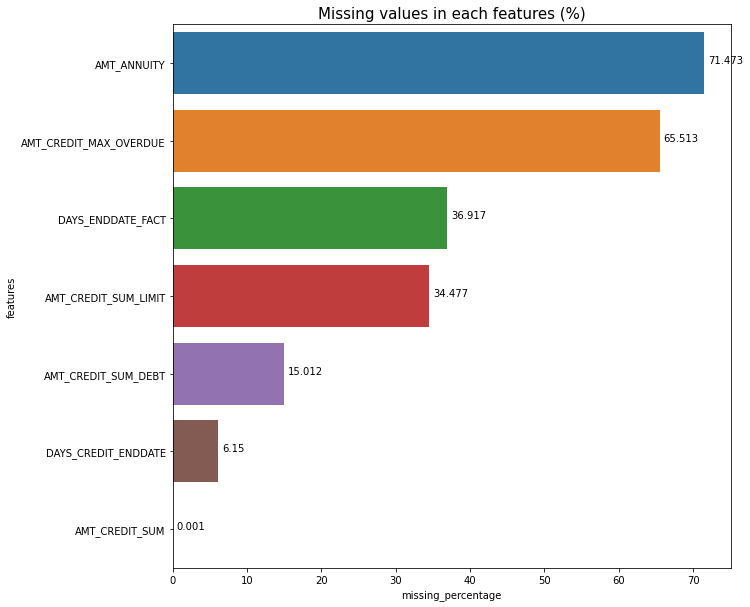

In [5]:
missing_values=pd.DataFrame(df_bureau.isnull().sum()*100/len(df_bureau)).reset_index()
missing_values.columns=['features','missing_percentage']

missing_values=missing_values[missing_values['missing_percentage']>0].sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_values

plt.figure(figsize=(10,10))
ax=sns.barplot(y="features", x="missing_percentage", data=missing_values, orient='h')
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Missing values in each features (%)', fontsize=15)



### 2.2 Categorical features

In [6]:
df_bureau.select_dtypes('object').columns

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

In [7]:
df_bureau_non_numeric=df_bureau[[column for column in df_bureau.select_dtypes('object').columns.tolist()]]
df_bureau_non_numeric.head()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
0,Closed,currency 1,Consumer credit
1,Active,currency 1,Credit card
2,Active,currency 1,Consumer credit
3,Active,currency 1,Credit card
4,Active,currency 1,Consumer credit


In [8]:
df_bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [9]:
df_bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [10]:
df_bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

In [11]:
# filtering credit_type 
counts=df_bureau['CREDIT_TYPE'].value_counts()
mask = df_bureau['CREDIT_TYPE'].isin(counts[counts < 1000].index)
df_bureau['CREDIT_TYPE'][mask] ='Other'

In [12]:
df_bureau['CREDIT_TYPE'].value_counts()

Consumer credit                  1251615
Credit card                       402195
Car loan                           27690
Mortgage                           18391
Microloan                          12413
Loan for business development       1975
Other                               1132
Another type of loan                1017
Name: CREDIT_TYPE, dtype: int64

##### Categorial_Count

In [13]:
def cat_count(df,group_by):
  """ takes a dataframe and calculates counts values of the categorial columns specified by the group_by column """
  d={}
  for column in df.select_dtypes('object').columns.tolist():
      cat_types=df[column].unique().tolist()
      for cat_type in cat_types:
        d["df_{}".format(cat_type)] = df[df[column]==cat_type].groupby(group_by, as_index=False)[column].count()
        d['df_{}'.format(cat_type)].rename(columns={'{}'.format(column):'count_{}_{}_type_{}'.format('bureau',column,cat_type)},inplace=True)
      dff=pd.concat([d[i].set_index('SK_ID_CURR') for i in d.keys()], axis=1).fillna(value=0).reset_index()
  return dff 

cat_count=cat_count(df=df_bureau, group_by='SK_ID_CURR')
cat_count.head()

,SK_ID_CURR,count_bureau_CREDIT_ACTIVE_type_Closed,count_bureau_CREDIT_ACTIVE_type_Active,count_bureau_CREDIT_ACTIVE_type_Sold,count_bureau_CREDIT_ACTIVE_type_Bad debt,count_bureau_CREDIT_CURRENCY_type_currency 1,count_bureau_CREDIT_CURRENCY_type_currency 2,count_bureau_CREDIT_CURRENCY_type_currency 4,count_bureau_CREDIT_CURRENCY_type_currency 3,count_bureau_CREDIT_TYPE_type_Consumer credit,count_bureau_CREDIT_TYPE_type_Credit card,count_bureau_CREDIT_TYPE_type_Mortgage,count_bureau_CREDIT_TYPE_type_Car loan,count_bureau_CREDIT_TYPE_type_Microloan,count_bureau_CREDIT_TYPE_type_Other,count_bureau_CREDIT_TYPE_type_Loan for business development,count_bureau_CREDIT_TYPE_type_Another type of loan
0,100001,4.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,6.0,2.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,3.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Categorial_Mode

In [14]:
cat_mode=df_bureau.groupby('SK_ID_CURR', as_index=False,)[df_bureau.select_dtypes('object').columns.tolist()].agg(lambda x: scipy.stats.mode(x)[0]).add_prefix('most_frequent_bureau_')
cat_mode.rename(columns={'most_frequent_bureau_SK_ID_CURR':'SK_ID_CURR'}, inplace=True)
cat_mode.head()

,SK_ID_CURR,most_frequent_bureau_CREDIT_ACTIVE,most_frequent_bureau_CREDIT_CURRENCY,most_frequent_bureau_CREDIT_TYPE
0,100001,Closed,currency 1,Consumer credit
1,100002,Closed,currency 1,Consumer credit
2,100003,Closed,currency 1,Consumer credit
3,100004,Closed,currency 1,Consumer credit
4,100005,Active,currency 1,Consumer credit


### 2.3 Numeric features

In [15]:
cat_features=df_bureau.select_dtypes('object').columns.to_list()

In [16]:
df_bureau_numeric=df_bureau.drop(cat_features, axis=1).apply(lambda x:abs(x))
df_bureau_numeric.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,497,0,153.0,153.0,NaN,0,91323.0,0.0,NaN,0.0,131,NaN
1,215354,5714463,208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,20,NaN
2,215354,5714464,203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,16,NaN
3,215354,5714465,203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,16,NaN
4,215354,5714466,629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,21,NaN


In [17]:
df_bureau_numeric.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

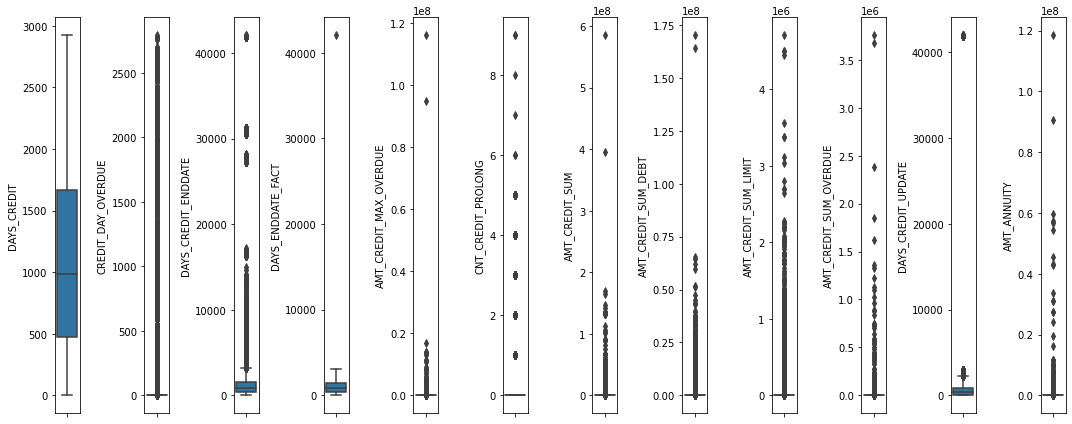

In [18]:
f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(1,12, figsize = (15,6))
sns.boxplot(y='DAYS_CREDIT', data=df_bureau_numeric, ax=ax1)
sns.boxplot(y='CREDIT_DAY_OVERDUE', data=df_bureau_numeric, ax=ax2)
sns.boxplot(y= 'DAYS_CREDIT_ENDDATE', data=df_bureau_numeric, ax=ax3)
sns.boxplot(y='DAYS_ENDDATE_FACT', data=df_bureau_numeric, ax=ax4)
sns.boxplot(y='AMT_CREDIT_MAX_OVERDUE', data=df_bureau_numeric, ax=ax5)
sns.boxplot(y= 'CNT_CREDIT_PROLONG', data=df_bureau_numeric, ax=ax6)
sns.boxplot(y= 'AMT_CREDIT_SUM', data=df_bureau_numeric, ax=ax7)
sns.boxplot(y='AMT_CREDIT_SUM_DEBT', data=df_bureau_numeric, ax=ax8)
sns.boxplot(y='AMT_CREDIT_SUM_LIMIT', data=df_bureau_numeric, ax=ax9)
sns.boxplot(y='AMT_CREDIT_SUM_OVERDUE', data=df_bureau_numeric, ax=ax10)
sns.boxplot(y= 'DAYS_CREDIT_UPDATE', data=df_bureau_numeric, ax=ax11)
sns.boxplot(y='AMT_ANNUITY', data=df_bureau_numeric, ax=ax12)

plt.tight_layout()


Let's drop some extreme values, which seems like an error in entry.

In [19]:
df_bureau_numeric['DAYS_ENDDATE_FACT'].sort_values(ascending=False)

198346     42023.0
1550542     3042.0
535407      2922.0
1522679     2919.0
1123734     2917.0
            ...   
1716404        NaN
1716410        NaN
1716412        NaN
1716417        NaN
1716423        NaN
Name: DAYS_ENDDATE_FACT, Length: 1716428, dtype: float64

In [20]:
df_bureau_numeric.drop(index=198346, inplace=True)

In [21]:
df_bureau_numeric['AMT_CREDIT_MAX_OVERDUE'].sort_values(ascending=False)

731333     115987185.0
819016      94812246.0
1258128     16950010.5
747916      14111390.7
491708      13975258.5
              ...     
1716421            NaN
1716422            NaN
1716425            NaN
1716426            NaN
1716427            NaN
Name: AMT_CREDIT_MAX_OVERDUE, Length: 1716427, dtype: float64

In [22]:
df_bureau_numeric.drop(index=[731333,819016], inplace=True)

In [23]:
df_bureau_numeric['AMT_CREDIT_SUM'].sort_values(ascending=False)

1515147    585000000.0
907821     396000000.0
489961     170100000.0
488411     164032200.0
1681052    146958507.0
              ...     
1113131            NaN
1172368            NaN
1176556            NaN
1176997            NaN
1268054            NaN
Name: AMT_CREDIT_SUM, Length: 1716425, dtype: float64

In [24]:
df_bureau_numeric.drop(index=[151547,907821], inplace=True)

In [25]:
df_bureau_numeric['AMT_CREDIT_SUM'].sort_values(ascending=False).head(10)

1515147    585000000.0
489961     170100000.0
488411     164032200.0
1681052    146958507.0
1190163    142290000.0
800744     135000000.0
488416     135000000.0
1239127    135000000.0
1615533    132750000.0
716827     132750000.0
Name: AMT_CREDIT_SUM, dtype: float64

In [26]:
df_bureau_numeric.drop(index=[1515147], inplace=True)

In [27]:
df_bureau_numeric['AMT_CREDIT_SUM_DEBT'].sort_values(ascending=False).head(10)

489961     170100000.0
488411     164032200.0
1653626     65441403.0
1609469     64570243.5
1701166     62218953.0
628833      59637690.0
1653624     51750000.0
824842      51365155.5
116227      47406861.0
1063507     44968383.0
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

In [28]:
df_bureau_numeric.drop(index=[489961,488411], inplace=True)

In [29]:
df_bureau_numeric['AMT_ANNUITY'].sort_values(ascending=False).head(10)

607473     118453423.5
1687167     90632371.5
650368      59586682.5
588794      57476227.5
1480286     56844981.0
1076015     54562657.5
1275852     45490630.5
831382      43286215.5
719450      42812998.2
1468707     33784668.0
Name: AMT_ANNUITY, dtype: float64

In [30]:
df_bureau_numeric.drop(index=[607473,1687167], inplace=True)

##### Aggregate

In [31]:
num_bureau_agg = df_bureau_numeric.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'median', 'max', 'min', 'sum','std','var']).reset_index()

num_bureau_agg.head()

SK_ID_CURR  DAYS_CREDIT                                                      \
                     mean  median   max  min   sum         std            var   
0     100001   735.000000   857.0  1572   49  5145  489.942514  240043.666667   
1     100002   874.000000  1042.5  1437  103  6992  431.451040  186150.000000   
2     100003  1400.750000  1205.5  2586  606  5603  909.826128  827783.583333   
3     100004   867.000000   867.0  1326  408  1734  649.124025  421362.000000   
4     100005   190.666667   137.0   373   62   572  162.297053   26340.333333   

  CREDIT_DAY_OVERDUE         ... DAYS_CREDIT_UPDATE              \
                mean median  ...                sum         std   
0                0.0    0.0  ...                652   77.204120   
1                0.0    0.0  ...               3999  518.522472   
2                0.0    0.0  ...               3264  908.053963   
3                0.0    0.0  ...               1064  212.132034   
4                0.0    0.0  ...                163   58.594653   

                  AMT_ANNUITY                                             \
             var         mean median      max  min      sum          std   
0    5960.476190  3545.357143    0.0  10822.5  0.0  24817.5  4800.607529   
1  268865.553571     0.000000    0.0      0.0  0.0      0.0     0.000000   
2  824562.000000          NaN    NaN      NaN  NaN      0.0          NaN   
3   45000.000000          NaN    NaN      NaN  NaN      0.0          NaN   
4    3433.333333  1420.500000    0.0   4261.5  0.0   4261.5  2460.378172   

                 
            var  
0  2.304583e+07  
1  0.000000e+00  
2           NaN  
3           NaN  
4  6.053461e+06  

[5 rows x 85 columns]

In [32]:
num_bureau_agg.columns=['bureau_'+'_'.join(col) for col in num_bureau_agg.columns.values]

In [33]:
num_bureau_agg=num_bureau_agg.rename(columns={'bureau_SK_ID_CURR_':'SK_ID_CURR'})
num_bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_median,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_std,bureau_DAYS_CREDIT_var,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_median,...,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_CREDIT_UPDATE_std,bureau_DAYS_CREDIT_UPDATE_var,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_median,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_std,bureau_AMT_ANNUITY_var
0,100001,735.000000,857.0,1572,49,5145,489.942514,240043.666667,0.0,0.0,...,652,77.204120,5960.476190,3545.357143,0.0,10822.5,0.0,24817.5,4800.607529,2.304583e+07
1,100002,874.000000,1042.5,1437,103,6992,431.451040,186150.000000,0.0,0.0,...,3999,518.522472,268865.553571,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00
2,100003,1400.750000,1205.5,2586,606,5603,909.826128,827783.583333,0.0,0.0,...,3264,908.053963,824562.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,100004,867.000000,867.0,1326,408,1734,649.124025,421362.000000,0.0,0.0,...,1064,212.132034,45000.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,100005,190.666667,137.0,373,62,572,162.297053,26340.333333,0.0,0.0,...,163,58.594653,3433.333333,1420.500000,0.0,4261.5,0.0,4261.5,2460.378172,6.053461e+06


##### Total no. of previous loans

In [34]:
previous_loan_counts=df_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'bureau_previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,bureau_previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


### Final Bureau

In [35]:
final_bureau=cat_count.merge(cat_mode, how='outer', on='SK_ID_CURR').merge(num_bureau_agg, how='outer', on='SK_ID_CURR').merge(previous_loan_counts, how='outer', on='SK_ID_CURR')
final_bureau.head()

,SK_ID_CURR,count_bureau_CREDIT_ACTIVE_type_Closed,count_bureau_CREDIT_ACTIVE_type_Active,count_bureau_CREDIT_ACTIVE_type_Sold,count_bureau_CREDIT_ACTIVE_type_Bad debt,count_bureau_CREDIT_CURRENCY_type_currency 1,count_bureau_CREDIT_CURRENCY_type_currency 2,count_bureau_CREDIT_CURRENCY_type_currency 4,count_bureau_CREDIT_CURRENCY_type_currency 3,count_bureau_CREDIT_TYPE_type_Consumer credit,...,bureau_DAYS_CREDIT_UPDATE_std,bureau_DAYS_CREDIT_UPDATE_var,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_median,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_std,bureau_AMT_ANNUITY_var,bureau_previous_loan_counts
0,100001,4.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,...,77.204120,5960.476190,3545.357143,0.0,10822.5,0.0,24817.5,4800.607529,2.304583e+07,7
1,100002,6.0,2.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,...,518.522472,268865.553571,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,8
2,100003,3.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,...,908.053963,824562.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4
3,100004,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,...,212.132034,45000.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2
4,100005,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,...,58.594653,3433.333333,1420.500000,0.0,4261.5,0.0,4261.5,2460.378172,6.053461e+06,3


In [36]:
final_bureau.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 0 to 305810
Data columns (total 105 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   SK_ID_CURR                                                   305811 non-null  int64  
 1   count_bureau_CREDIT_ACTIVE_type_Closed                       305811 non-null  float64
 2   count_bureau_CREDIT_ACTIVE_type_Active                       305811 non-null  float64
 3   count_bureau_CREDIT_ACTIVE_type_Sold                         305811 non-null  float64
 4   count_bureau_CREDIT_ACTIVE_type_Bad debt                     305811 non-null  float64
 5   count_bureau_CREDIT_CURRENCY_type_currency 1                 305811 non-null  float64
 6   count_bureau_CREDIT_CURRENCY_type_currency 2                 305811 non-null  float64
 7   count_bureau_CREDIT_CURRENCY_type_currency 4                 305

## 3) Bureau Balance


#### 3.1 Data Overview
This is a monthly data about the previous credits of the applicants in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

In [37]:
df_bureau_balance=pd.read_csv('Original_data/bureau_balance.csv')
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [38]:
df_bureau_balance.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   SK_ID_BUREAU    27299925 non-null  int64 
 1   MONTHS_BALANCE  27299925 non-null  int64 
 2   STATUS          27299925 non-null  object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


#### 3.2 Categorial Features

In [39]:
cat_features=df_bureau_balance.select_dtypes('object').columns
cat_features

Index(['STATUS'], dtype='object')

In [40]:
df_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [41]:
df_bureau_balance.select_dtypes('object').columns.tolist()

['STATUS']

In [42]:
def cat_count(df,group_by):
  """ takes a dataframe and calculates counts values of the categorial columns specied by the group_by column """
  d={}
  for column in df.select_dtypes('object').columns.tolist():
      cat_types=df[column].unique().tolist()
      for cat_type in cat_types:
        d["df_{}".format(cat_type)] = df[df[column]==cat_type].groupby(group_by, as_index=False)[column].count()
        d['df_{}'.format(cat_type)].rename(columns={'{}'.format(column):'count_{}_{}_type_{}'.format('bureau_balance',column,cat_type)},inplace=True)
      dff=pd.concat([d[i].set_index('SK_ID_BUREAU') for i in d.keys()], axis=1).fillna(value=0).reset_index()
  return dff 

cat_count_bureau_balance=cat_count(df=df_bureau_balance, group_by='SK_ID_BUREAU')
cat_count_bureau_balance.head()

,SK_ID_BUREAU,count_bureau_balance_STATUS_type_C,count_bureau_balance_STATUS_type_0,count_bureau_balance_STATUS_type_X,count_bureau_balance_STATUS_type_1,count_bureau_balance_STATUS_type_2,count_bureau_balance_STATUS_type_3,count_bureau_balance_STATUS_type_5,count_bureau_balance_STATUS_type_4
0,5001709,86.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
1,5001710,48.0,5.0,30.0,0.0,0.0,0.0,0.0,0.0
2,5001711,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5001712,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5001713,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0


In [43]:
cat_count_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817395 entries, 0 to 817394
Data columns (total 9 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   SK_ID_BUREAU                        817395 non-null  int64  
 1   count_bureau_balance_STATUS_type_C  817395 non-null  float64
 2   count_bureau_balance_STATUS_type_0  817395 non-null  float64
 3   count_bureau_balance_STATUS_type_X  817395 non-null  float64
 4   count_bureau_balance_STATUS_type_1  817395 non-null  float64
 5   count_bureau_balance_STATUS_type_2  817395 non-null  float64
 6   count_bureau_balance_STATUS_type_3  817395 non-null  float64
 7   count_bureau_balance_STATUS_type_5  817395 non-null  float64
 8   count_bureau_balance_STATUS_type_4  817395 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 56.1 MB


#### 3.3 Numeric Features

In [44]:
df_bureau_balance['MONTHS_BALANCE'].value_counts()

-1     622601
-2     619243
-3     615080
 0     610965
-4     609138
        ...  
-92     57300
-93     53535
-94     49965
-95     46542
-96     43147
Name: MONTHS_BALANCE, Length: 97, dtype: int64

In [45]:
df_bureau_balance['MONTHS_BALANCE']=df_bureau_balance['MONTHS_BALANCE'].apply(lambda x: abs(x))

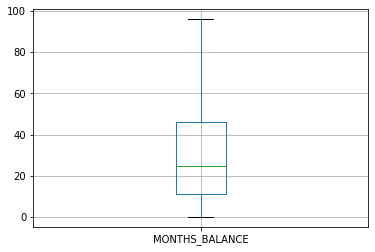

In [46]:
df_bureau_balance[['MONTHS_BALANCE']].boxplot()

In [47]:
num_bureau_balance_agg = df_bureau_balance.drop('STATUS', axis=1).groupby('SK_ID_BUREAU', as_index = False).agg(['mean', 'median','max', 'min', 'sum','std','var']).reset_index()

num_bureau_balance_agg.head()

SK_ID_BUREAU MONTHS_BALANCE                                            
                         mean median max min   sum        std         var
0      5001709           48.0   48.0  96   0  4656  28.145456  792.166667
1      5001710           41.0   41.0  82   0  3403  24.103942  581.000000
2      5001711            1.5    1.5   3   0     6   1.290994    1.666667
3      5001712            9.0    9.0  18   0   171   5.627314   31.666667
4      5001713           10.5   10.5  21   0   231   6.493587   42.166667

In [48]:
num_bureau_balance_agg.columns=['bureau_balance_'+'_'.join(col) for col in num_bureau_balance_agg.columns.values]
num_bureau_balance_agg=num_bureau_balance_agg.rename(columns={'bureau_balance_SK_ID_BUREAU_':'SK_ID_BUREAU'})
num_bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_median,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_std,bureau_balance_MONTHS_BALANCE_var
0,5001709,48.0,48.0,96,0,4656,28.145456,792.166667
1,5001710,41.0,41.0,82,0,3403,24.103942,581.000000
2,5001711,1.5,1.5,3,0,6,1.290994,1.666667
3,5001712,9.0,9.0,18,0,171,5.627314,31.666667
4,5001713,10.5,10.5,21,0,231,6.493587,42.166667


### Final bureau_balance

In [49]:
bureau_balance=cat_count_bureau_balance.merge(num_bureau_balance_agg, how='outer', on='SK_ID_BUREAU')
bureau_balance.head()

,SK_ID_BUREAU,count_bureau_balance_STATUS_type_C,count_bureau_balance_STATUS_type_0,count_bureau_balance_STATUS_type_X,count_bureau_balance_STATUS_type_1,count_bureau_balance_STATUS_type_2,count_bureau_balance_STATUS_type_3,count_bureau_balance_STATUS_type_5,count_bureau_balance_STATUS_type_4,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_median,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_std,bureau_balance_MONTHS_BALANCE_var
0,5001709,86.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,48.0,48.0,96,0,4656,28.145456,792.166667
1,5001710,48.0,5.0,30.0,0.0,0.0,0.0,0.0,0.0,41.0,41.0,82,0,3403,24.103942,581.000000
2,5001711,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,1.5,3,0,6,1.290994,1.666667
3,5001712,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,18,0,171,5.627314,31.666667
4,5001713,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,10.5,10.5,21,0,231,6.493587,42.166667


In [50]:
df_bureau1=df_bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
df_bureau1.head()

,SK_ID_CURR,SK_ID_BUREAU
0,215354,5714462
1,215354,5714463
2,215354,5714464
3,215354,5714465
4,215354,5714466


In [51]:
bureau_balance1=bureau_balance.merge(df_bureau1, how='left', on='SK_ID_BUREAU')
bureau_balance1.head()

,SK_ID_BUREAU,count_bureau_balance_STATUS_type_C,count_bureau_balance_STATUS_type_0,count_bureau_balance_STATUS_type_X,count_bureau_balance_STATUS_type_1,count_bureau_balance_STATUS_type_2,count_bureau_balance_STATUS_type_3,count_bureau_balance_STATUS_type_5,count_bureau_balance_STATUS_type_4,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_median,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_std,bureau_balance_MONTHS_BALANCE_var,SK_ID_CURR
0,5001709,86.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,48.0,48.0,96,0,4656,28.145456,792.166667,NaN
1,5001710,48.0,5.0,30.0,0.0,0.0,0.0,0.0,0.0,41.0,41.0,82,0,3403,24.103942,581.000000,162368.0
2,5001711,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,1.5,3,0,6,1.290994,1.666667,162368.0
3,5001712,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,18,0,171,5.627314,31.666667,162368.0
4,5001713,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,10.5,10.5,21,0,231,6.493587,42.166667,150635.0


In [52]:
final_bureau_balance=bureau_balance1.drop('SK_ID_BUREAU', axis=1).groupby('SK_ID_CURR', as_index=False).mean()
final_bureau_balance.head()

,SK_ID_CURR,count_bureau_balance_STATUS_type_C,count_bureau_balance_STATUS_type_0,count_bureau_balance_STATUS_type_X,count_bureau_balance_STATUS_type_1,count_bureau_balance_STATUS_type_2,count_bureau_balance_STATUS_type_3,count_bureau_balance_STATUS_type_5,count_bureau_balance_STATUS_type_4,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_median,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_std,bureau_balance_MONTHS_BALANCE_var
0,100001.0,15.714286,4.428571,4.285714,0.142857,0.0,0.0,0.0,0.0,11.785714,11.785714,23.571429,0.0,400.000000,7.234085,70.761905
1,100002.0,2.875000,5.625000,1.875000,3.375000,0.0,0.0,0.0,0.0,21.875000,21.875000,28.250000,15.5,337.625000,4.110042,19.854167
2,100005.0,1.666667,4.666667,0.666667,0.000000,0.0,0.0,0.0,0.0,3.000000,3.000000,6.000000,0.0,30.333333,2.158526,6.222222
3,100010.0,26.000000,10.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,46.000000,46.000000,63.500000,28.5,1656.000000,10.535654,111.000000
4,100013.0,25.750000,19.750000,10.250000,1.750000,0.0,0.0,0.0,0.0,28.250000,28.250000,56.500000,0.0,1689.000000,16.742507,291.083333


In [53]:
final_bureau_balance.columns=['mean_'+str(col) for col in final_bureau_balance.columns]
final_bureau_balance=final_bureau_balance.rename(columns={'mean_SK_ID_CURR':'SK_ID_CURR'})
final_bureau_balance['SK_ID_CURR']=final_bureau_balance['SK_ID_CURR'].astype(int)
final_bureau_balance.head()

,SK_ID_CURR,mean_count_bureau_balance_STATUS_type_C,mean_count_bureau_balance_STATUS_type_0,mean_count_bureau_balance_STATUS_type_X,mean_count_bureau_balance_STATUS_type_1,mean_count_bureau_balance_STATUS_type_2,mean_count_bureau_balance_STATUS_type_3,mean_count_bureau_balance_STATUS_type_5,mean_count_bureau_balance_STATUS_type_4,mean_bureau_balance_MONTHS_BALANCE_mean,mean_bureau_balance_MONTHS_BALANCE_median,mean_bureau_balance_MONTHS_BALANCE_max,mean_bureau_balance_MONTHS_BALANCE_min,mean_bureau_balance_MONTHS_BALANCE_sum,mean_bureau_balance_MONTHS_BALANCE_std,mean_bureau_balance_MONTHS_BALANCE_var
0,100001,15.714286,4.428571,4.285714,0.142857,0.0,0.0,0.0,0.0,11.785714,11.785714,23.571429,0.0,400.000000,7.234085,70.761905
1,100002,2.875000,5.625000,1.875000,3.375000,0.0,0.0,0.0,0.0,21.875000,21.875000,28.250000,15.5,337.625000,4.110042,19.854167
2,100005,1.666667,4.666667,0.666667,0.000000,0.0,0.0,0.0,0.0,3.000000,3.000000,6.000000,0.0,30.333333,2.158526,6.222222
3,100010,26.000000,10.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,46.000000,46.000000,63.500000,28.5,1656.000000,10.535654,111.000000
4,100013,25.750000,19.750000,10.250000,1.750000,0.0,0.0,0.0,0.0,28.250000,28.250000,56.500000,0.0,1689.000000,16.742507,291.083333


## 4) Credit Card Balance

#### 4.1 Data Overview
This is monthly data about previous credit cards applicants have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

In [54]:
df_cc_balance=pd.read_csv('Original_data/credit_card_balance.csv')
df_cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [55]:
df_cc_balance.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   SK_ID_PREV                  3840312 non-null  int64  
 1   SK_ID_CURR                  3840312 non-null  int64  
 2   MONTHS_BALANCE              3840312 non-null  int64  
 3   AMT_BALANCE                 3840312 non-null  float64
 4   AMT_CREDIT_LIMIT_ACTUAL     3840312 non-null  int64  
 5   AMT_DRAWINGS_ATM_CURRENT    3090496 non-null  float64
 6   AMT_DRAWINGS_CURRENT        3840312 non-null  float64
 7   AMT_DRAWINGS_OTHER_CURRENT  3090496 non-null  float64
 8   AMT_DRAWINGS_POS_CURRENT    3090496 non-null  float64
 9   AMT_INST_MIN_REGULARITY     3535076 non-null  float64
 10  AMT_PAYMENT_CURRENT         3072324 non-null  float64
 11  AMT_PAYMENT_TOTAL_CURRENT   3840312 non-null  float64
 12  AMT_RECEIVABLE_PRINCIPAL    3840312 non-null  float64
 1

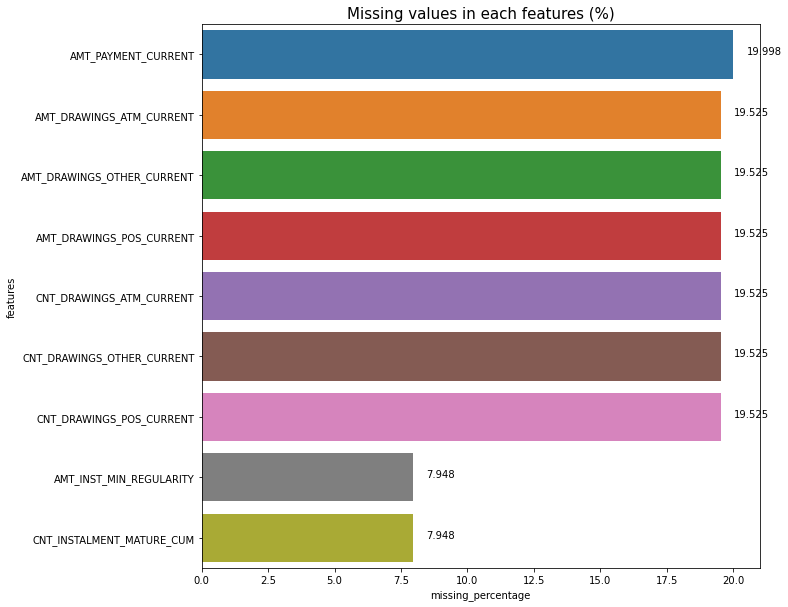

In [56]:
missing_values=pd.DataFrame(df_cc_balance.isnull().sum()*100/len(df_cc_balance)).reset_index()
missing_values.columns=['features','missing_percentage']

missing_values=missing_values[missing_values['missing_percentage']>0].sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_values

plt.figure(figsize=(10,10))
ax=sns.barplot(y="features", x="missing_percentage", data=missing_values, orient='h')
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Missing values in each features (%)', fontsize=15)



### 4.2 Categorical Features

In [57]:
cat_features=df_cc_balance.select_dtypes('object').columns
cat_features

Index(['NAME_CONTRACT_STATUS'], dtype='object')

##### Categorical count

In [58]:
df_cc_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [59]:
def cat_count(df,group_by):
  """ takes a dataframe and calculates counts values of the categorial columns specied by the group_by column """
  d={}
  for column in df.select_dtypes('object').columns.tolist():
      cat_types=df[column].unique().tolist()
      for cat_type in cat_types:
        d["df_{}".format(cat_type)] = df[df[column]==cat_type].groupby(group_by, as_index=False)[column].count()
        d['df_{}'.format(cat_type)].rename(columns={'{}'.format(column):'count_{}_{}_type_{}'.format('cc_balance',column,cat_type)},inplace=True)
      dff=pd.concat([d[i].set_index('SK_ID_CURR') for i in d.keys()], axis=1).fillna(value=0).reset_index()
  return dff 

cat_count_cc_balance=cat_count(df=df_cc_balance, group_by='SK_ID_CURR')
cat_count_cc_balance.head()

,SK_ID_CURR,count_cc_balance_NAME_CONTRACT_STATUS_type_Active,count_cc_balance_NAME_CONTRACT_STATUS_type_Completed,count_cc_balance_NAME_CONTRACT_STATUS_type_Demand,count_cc_balance_NAME_CONTRACT_STATUS_type_Signed,count_cc_balance_NAME_CONTRACT_STATUS_type_Sent proposal,count_cc_balance_NAME_CONTRACT_STATUS_type_Refused,count_cc_balance_NAME_CONTRACT_STATUS_type_Approved
0,100006,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,74.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,96.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100021,7.0,10.0,0.0,0.0,0.0,0.0,0.0
4,100023,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
cat_count_cc_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103558 entries, 0 to 103557
Data columns (total 8 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   SK_ID_CURR                                                103558 non-null  int64  
 1   count_cc_balance_NAME_CONTRACT_STATUS_type_Active         103558 non-null  float64
 2   count_cc_balance_NAME_CONTRACT_STATUS_type_Completed      103558 non-null  float64
 3   count_cc_balance_NAME_CONTRACT_STATUS_type_Demand         103558 non-null  float64
 4   count_cc_balance_NAME_CONTRACT_STATUS_type_Signed         103558 non-null  float64
 5   count_cc_balance_NAME_CONTRACT_STATUS_type_Sent proposal  103558 non-null  float64
 6   count_cc_balance_NAME_CONTRACT_STATUS_type_Refused        103558 non-null  float64
 7   count_cc_balance_NAME_CONTRACT_STATUS_type_Approved       103558 non-null  float64
dtypes: fl

#### Categorical_mode

In [61]:
mode_credit_card_balance=df_cc_balance[['SK_ID_CURR','NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR', as_index=False,).agg(lambda x: scipy.stats.mode(x)[0]).add_prefix('most_frequent_cc_balance_')
mode_credit_card_balance=mode_credit_card_balance.rename(columns={'most_frequent_cc_balance_SK_ID_CURR':'SK_ID_CURR'})
mode_credit_card_balance.head()

,SK_ID_CURR,most_frequent_cc_balance_NAME_CONTRACT_STATUS
0,100006,Active
1,100011,Active
2,100013,Active
3,100021,Completed
4,100023,Active


### 4.3 Numerical Features

In [62]:
df_credit_card_balance_numeric=df_cc_balance.drop('NAME_CONTRACT_STATUS', axis=1)
df_credit_card_balance_numeric=df_credit_card_balance_numeric.apply(lambda x:abs(x))
df_credit_card_balance_numeric.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,2562384,378907,6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,0,0
1,2582071,363914,1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,0,0
2,1740877,371185,7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,0,0
3,1389973,337855,4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,0,0
4,1891521,126868,1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,0,0


In [63]:
df_credit_card_balance_numeric.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')

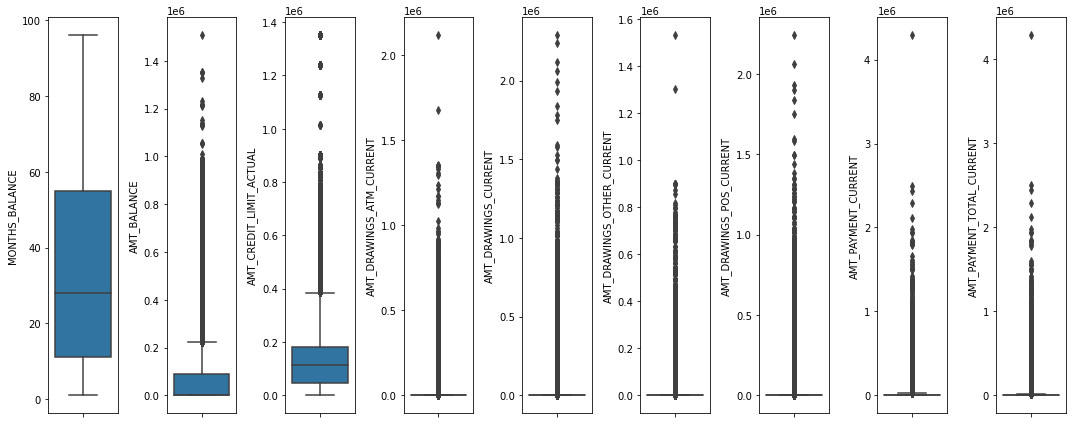

In [64]:
f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(1,9, figsize = (15,6))
sns.boxplot(y='MONTHS_BALANCE', data=df_credit_card_balance_numeric, ax=ax1)
sns.boxplot(y='AMT_BALANCE', data=df_credit_card_balance_numeric, ax=ax2)
sns.boxplot(y= 'AMT_CREDIT_LIMIT_ACTUAL', data=df_credit_card_balance_numeric, ax=ax3)
sns.boxplot(y='AMT_DRAWINGS_ATM_CURRENT', data=df_credit_card_balance_numeric, ax=ax4)
sns.boxplot(y='AMT_DRAWINGS_CURRENT', data=df_credit_card_balance_numeric, ax=ax5)
sns.boxplot(y= 'AMT_DRAWINGS_OTHER_CURRENT', data=df_credit_card_balance_numeric, ax=ax6)
sns.boxplot(y=  'AMT_DRAWINGS_POS_CURRENT', data=df_credit_card_balance_numeric, ax=ax7)
sns.boxplot(y='AMT_PAYMENT_CURRENT', data=df_credit_card_balance_numeric, ax=ax8)
sns.boxplot(y='AMT_PAYMENT_TOTAL_CURRENT', data=df_credit_card_balance_numeric, ax=ax9)

plt.tight_layout()



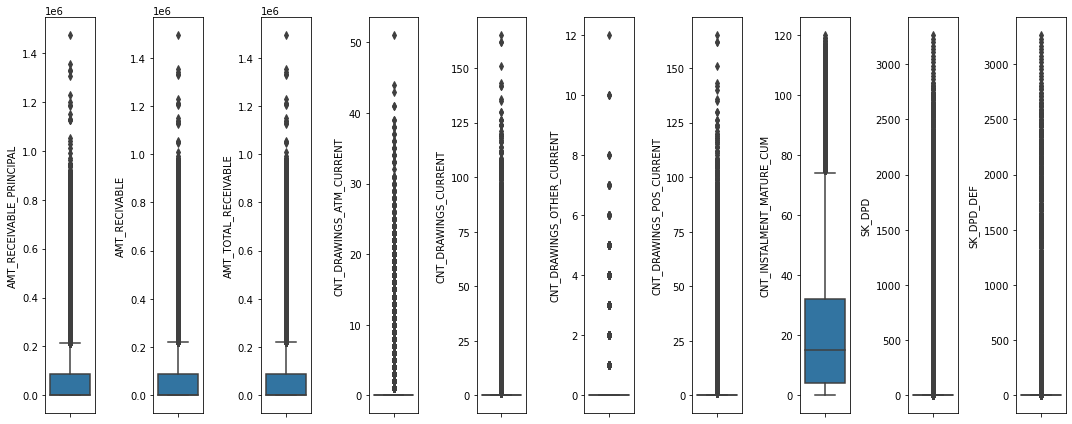

In [65]:
f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1,10, figsize = (15,6))
sns.boxplot(y='AMT_RECEIVABLE_PRINCIPAL', data=df_credit_card_balance_numeric, ax=ax1)
sns.boxplot(y= 'AMT_RECIVABLE', data=df_credit_card_balance_numeric, ax=ax2)
sns.boxplot(y='AMT_TOTAL_RECEIVABLE', data=df_credit_card_balance_numeric, ax=ax3)
sns.boxplot(y='CNT_DRAWINGS_ATM_CURRENT', data=df_credit_card_balance_numeric, ax=ax4)
sns.boxplot(y='CNT_DRAWINGS_CURRENT', data=df_credit_card_balance_numeric, ax=ax5)
sns.boxplot(y= 'CNT_DRAWINGS_OTHER_CURRENT', data=df_credit_card_balance_numeric, ax=ax6)
sns.boxplot(y= 'CNT_DRAWINGS_POS_CURRENT', data=df_credit_card_balance_numeric, ax=ax7)
sns.boxplot(y='CNT_INSTALMENT_MATURE_CUM', data=df_credit_card_balance_numeric, ax=ax8)
sns.boxplot(y='SK_DPD', data=df_credit_card_balance_numeric, ax=ax9)
sns.boxplot(y='SK_DPD_DEF', data=df_credit_card_balance_numeric, ax=ax10)

plt.tight_layout()


There are outliers, however the value seems legit.

In [66]:
num_credit_card_balance_agg = df_credit_card_balance_numeric.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'median','max', 'min', 'sum','std', 'var']).reset_index()
num_credit_card_balance_agg.columns=['credit_card_balance_'+'_'.join(col) for col in num_credit_card_balance_agg.columns.values]
num_credit_card_balance_agg=num_credit_card_balance_agg.rename(columns={'credit_card_balance_SK_ID_CURR_':'SK_ID_CURR'})
num_credit_card_balance_agg.head()

,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_median,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_MONTHS_BALANCE_std,credit_card_balance_MONTHS_BALANCE_var,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_median,...,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_std,credit_card_balance_SK_DPD_var,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_median,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum,credit_card_balance_SK_DPD_DEF_std,credit_card_balance_SK_DPD_DEF_var
0,100006,3.5,3.5,6,1,21,1.870829,3.5,0.000000,0.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
1,100011,38.5,38.5,75,2,2849,21.505813,462.5,54482.111149,0.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
2,100013,48.5,48.5,96,1,4656,27.856777,776.0,18159.919219,0.0,...,1,0.102062,0.010417,0.010417,0.0,1,0,1,0.102062,0.010417
3,100021,10.0,10.0,18,2,170,5.049752,25.5,0.000000,0.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
4,100023,7.5,7.5,11,4,60,2.449490,6.0,0.000000,0.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000


In [67]:
previous_credit_card_count=df_cc_balance.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV': 'credit_card_balance_previous_credit_card_counts'})
previous_credit_card_count.head()

,SK_ID_CURR,credit_card_balance_previous_credit_card_counts
0,100006,6
1,100011,74
2,100013,96
3,100021,17
4,100023,8


### Final CC Balance

In [68]:
final_cc_balance=num_credit_card_balance_agg.merge(previous_credit_card_count, on='SK_ID_CURR', how='outer').merge(mode_credit_card_balance, on='SK_ID_CURR', how='outer').merge(cat_count_cc_balance, on='SK_ID_CURR', how='outer')
final_cc_balance.head()

,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_median,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_MONTHS_BALANCE_std,credit_card_balance_MONTHS_BALANCE_var,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_median,...,credit_card_balance_SK_DPD_DEF_var,credit_card_balance_previous_credit_card_counts,most_frequent_cc_balance_NAME_CONTRACT_STATUS,count_cc_balance_NAME_CONTRACT_STATUS_type_Active,count_cc_balance_NAME_CONTRACT_STATUS_type_Completed,count_cc_balance_NAME_CONTRACT_STATUS_type_Demand,count_cc_balance_NAME_CONTRACT_STATUS_type_Signed,count_cc_balance_NAME_CONTRACT_STATUS_type_Sent proposal,count_cc_balance_NAME_CONTRACT_STATUS_type_Refused,count_cc_balance_NAME_CONTRACT_STATUS_type_Approved
0,100006,3.5,3.5,6,1,21,1.870829,3.5,0.000000,0.0,...,0.000000,6,Active,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,38.5,38.5,75,2,2849,21.505813,462.5,54482.111149,0.0,...,0.000000,74,Active,74.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,48.5,48.5,96,1,4656,27.856777,776.0,18159.919219,0.0,...,0.010417,96,Active,96.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100021,10.0,10.0,18,2,170,5.049752,25.5,0.000000,0.0,...,0.000000,17,Completed,7.0,10.0,0.0,0.0,0.0,0.0,0.0
4,100023,7.5,7.5,11,4,60,2.449490,6.0,0.000000,0.0,...,0.000000,8,Active,8.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5) Installments Payment


#### 5.1 Data Overview
This is payment history of the applicants for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [69]:
df_installments_payments=pd.read_csv('Original_data/installments_payments.csv')
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [70]:
df_installments_payments.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int64  
 1   SK_ID_CURR              13605401 non-null  int64  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float64
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int64  
 4   DAYS_INSTALMENT         13605401 non-null  float64
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float64
 6   AMT_INSTALMENT          13605401 non-null  float64
 7   AMT_PAYMENT             13602496 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


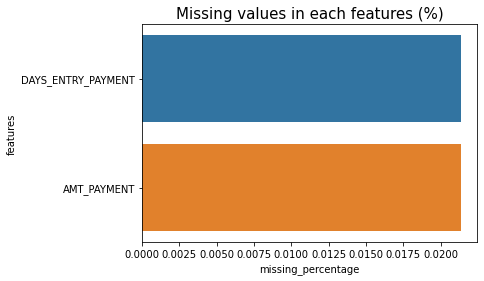

In [71]:
missing_values=pd.DataFrame(df_installments_payments.isnull().sum()*100/len(df_installments_payments)).reset_index()
missing_values.columns=['features','missing_percentage']

missing_values=missing_values[missing_values['missing_percentage']>0].sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_values

plt.figure(figsize=(6,4))
ax=sns.barplot(y="features", x="missing_percentage", data=missing_values, orient='h')

_=ax.set_title('Missing values in each features (%)', fontsize=15)



Very few missing values.

#### 5.2 Numeric Features

In [72]:
cat_features=df_installments_payments.select_dtypes('object').columns
cat_features

Index([], dtype='object')

In [73]:
Num_features=df_installments_payments.columns
Num_features

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

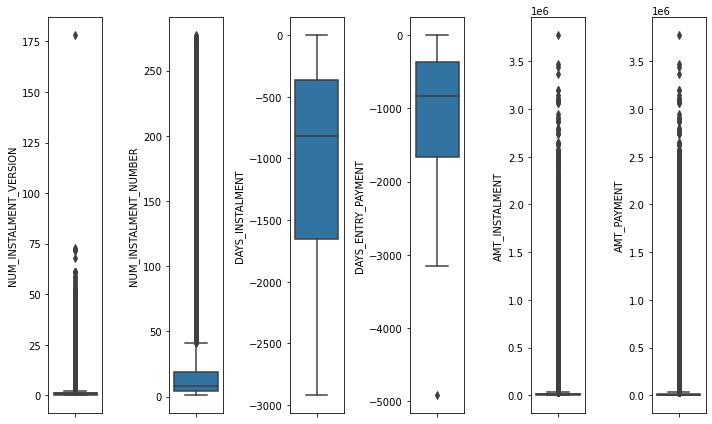

In [74]:
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize = (10,6))
sns.boxplot(y='NUM_INSTALMENT_VERSION', data=df_installments_payments, ax=ax1)
sns.boxplot(y='NUM_INSTALMENT_NUMBER', data=df_installments_payments, ax=ax2)
sns.boxplot(y= 'DAYS_INSTALMENT', data=df_installments_payments, ax=ax3)
sns.boxplot(y='DAYS_ENTRY_PAYMENT', data=df_installments_payments, ax=ax4)
sns.boxplot(y='AMT_INSTALMENT', data=df_installments_payments, ax=ax5)
sns.boxplot(y= 'AMT_PAYMENT', data=df_installments_payments, ax=ax6)

plt.tight_layout()



There are outliers and most of them seemss legit, except the max value of NUM_INSTALLMENT VERSION. Let's drop that value.

In [75]:
df_installments_payments['NUM_INSTALMENT_VERSION'].sort_values(ascending=False)

7580806     178.0
11324478     73.0
9059074      72.0
9850838      72.0
11305632     72.0
            ...  
10292356      0.0
4367654       0.0
4367655       0.0
10292353      0.0
10669485      0.0
Name: NUM_INSTALMENT_VERSION, Length: 13605401, dtype: float64

In [76]:
df_installments_payments.drop(index=7580806, inplace=True)

In [77]:
num_installments_payments_agg = df_installments_payments.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['mean','median','max', 'min', 'sum','std','var']).reset_index()
num_installments_payments_agg.columns=['installments_payments_'+ '_'.join(col) for col in num_installments_payments_agg.columns.values]
num_installments_payments_agg=num_installments_payments_agg.rename(columns={'installments_payments_SK_ID_CURR_':'SK_ID_CURR'})
num_installments_payments_agg.head()

,SK_ID_CURR,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_median,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_VERSION_std,installments_payments_NUM_INSTALMENT_VERSION_var,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_median,...,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_INSTALMENT_std,installments_payments_AMT_INSTALMENT_var,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_median,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum,installments_payments_AMT_PAYMENT_std,installments_payments_AMT_PAYMENT_var
0,100001,1.142857,1.0,2.0,1.0,8.0,0.377964,0.142857,2.714286,3.0,...,41195.925,5076.676624,2.577265e+07,5885.132143,3980.925,17397.900,3951.000,41195.925,5076.676624,2.577265e+07
1,100002,1.052632,1.0,2.0,1.0,20.0,0.229416,0.052632,10.000000,10.0,...,219625.695,10058.037722,1.011641e+08,11559.247105,9251.775,53093.745,9251.775,219625.695,10058.037722,1.011641e+08
2,100003,1.040000,1.0,2.0,1.0,26.0,0.200000,0.040000,5.080000,5.0,...,1618864.650,110542.592300,1.221966e+10,64754.586000,64275.615,560835.360,6662.970,1618864.650,110542.592300,1.221966e+10
3,100004,1.333333,1.0,2.0,1.0,4.0,0.577350,0.333333,2.000000,2.0,...,21288.465,3011.871810,9.071372e+06,7096.155000,5357.250,10573.965,5357.250,21288.465,3011.871810,9.071372e+06
4,100005,1.111111,1.0,2.0,1.0,10.0,0.333333,0.111111,5.000000,5.0,...,56161.845,4281.015000,1.832709e+07,6240.205000,4813.200,17656.245,4813.200,56161.845,4281.015000,1.832709e+07


In [78]:
previous_installment_payments_count=df_installments_payments.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV': 'installments_payments_previous_installments_counts'})
previous_installment_payments_count.head()

,SK_ID_CURR,installments_payments_previous_installments_counts
0,100001,7
1,100002,19
2,100003,25
3,100004,3
4,100005,9


#### final Installment Payment

In [79]:
final_installment_payments=num_installments_payments_agg.merge(previous_installment_payments_count, how='outer', on='SK_ID_CURR')
final_installment_payments.head()

,SK_ID_CURR,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_median,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_VERSION_std,installments_payments_NUM_INSTALMENT_VERSION_var,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_median,...,installments_payments_AMT_INSTALMENT_std,installments_payments_AMT_INSTALMENT_var,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_median,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum,installments_payments_AMT_PAYMENT_std,installments_payments_AMT_PAYMENT_var,installments_payments_previous_installments_counts
0,100001,1.142857,1.0,2.0,1.0,8.0,0.377964,0.142857,2.714286,3.0,...,5076.676624,2.577265e+07,5885.132143,3980.925,17397.900,3951.000,41195.925,5076.676624,2.577265e+07,7
1,100002,1.052632,1.0,2.0,1.0,20.0,0.229416,0.052632,10.000000,10.0,...,10058.037722,1.011641e+08,11559.247105,9251.775,53093.745,9251.775,219625.695,10058.037722,1.011641e+08,19
2,100003,1.040000,1.0,2.0,1.0,26.0,0.200000,0.040000,5.080000,5.0,...,110542.592300,1.221966e+10,64754.586000,64275.615,560835.360,6662.970,1618864.650,110542.592300,1.221966e+10,25
3,100004,1.333333,1.0,2.0,1.0,4.0,0.577350,0.333333,2.000000,2.0,...,3011.871810,9.071372e+06,7096.155000,5357.250,10573.965,5357.250,21288.465,3011.871810,9.071372e+06,3
4,100005,1.111111,1.0,2.0,1.0,10.0,0.333333,0.111111,5.000000,5.0,...,4281.015000,1.832709e+07,6240.205000,4813.200,17656.245,4813.200,56161.845,4281.015000,1.832709e+07,9


## 6) POS_CASH_balance


### 6.1 Data Overview
This is monthly data about previous point of sale or cash loans applicants have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

In [80]:
df_POS_CASH_balance=pd.read_csv('Original_data/POS_CASH_balance.csv')
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [81]:
df_POS_CASH_balance.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   SK_ID_PREV             10001358 non-null  int64  
 1   SK_ID_CURR             10001358 non-null  int64  
 2   MONTHS_BALANCE         10001358 non-null  int64  
 3   CNT_INSTALMENT         9975287 non-null   float64
 4   CNT_INSTALMENT_FUTURE  9975271 non-null   float64
 5   NAME_CONTRACT_STATUS   10001358 non-null  object 
 6   SK_DPD                 10001358 non-null  int64  
 7   SK_DPD_DEF             10001358 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


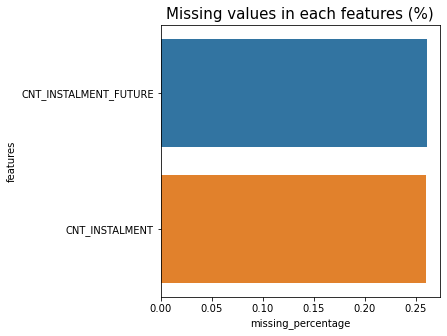

In [82]:
missing_values=pd.DataFrame(df_POS_CASH_balance.isnull().sum()*100/len(df_POS_CASH_balance)).reset_index()
missing_values.columns=['features','missing_percentage']

missing_values=missing_values[missing_values['missing_percentage']>0].sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_values

plt.figure(figsize=(5,5))
ax=sns.barplot(y="features", x="missing_percentage", data=missing_values, orient='h')

_=ax.set_title('Missing values in each features (%)', fontsize=15)



Very few missing values.

### 6.2 Categorical Features

In [83]:
cat_features=df_POS_CASH_balance.select_dtypes('object').columns
cat_features

Index(['NAME_CONTRACT_STATUS'], dtype='object')

In [84]:
df_POS_CASH_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [85]:
df_POS_CASH_balance=df_POS_CASH_balance[df_POS_CASH_balance['NAME_CONTRACT_STATUS']!='XNA']

In [86]:
def cat_count(df,group_by):
  """ takes a dataframe and calculates counts values of the categorial columns specied by the group_by column """
  d={}
  for column in df.select_dtypes('object').columns.tolist():
      cat_types=df[column].unique().tolist()
      for cat_type in cat_types:
        d["df_{}".format(cat_type)] = df[df[column]==cat_type].groupby(group_by, as_index=False)[column].count()
        d['df_{}'.format(cat_type)].rename(columns={'{}'.format(column):'count_{}_{}_type_{}'.format('POS',column,cat_type)},inplace=True)
      dff=pd.concat([d[i].set_index('SK_ID_CURR') for i in d.keys()], axis=1).fillna(value=0).reset_index()
  return dff 

cat_count_POS=cat_count(df=df_POS_CASH_balance, group_by='SK_ID_CURR')
cat_count_POS.head()

,SK_ID_CURR,count_POS_NAME_CONTRACT_STATUS_type_Active,count_POS_NAME_CONTRACT_STATUS_type_Completed,count_POS_NAME_CONTRACT_STATUS_type_Signed,count_POS_NAME_CONTRACT_STATUS_type_Approved,count_POS_NAME_CONTRACT_STATUS_type_Returned to the store,count_POS_NAME_CONTRACT_STATUS_type_Demand,count_POS_NAME_CONTRACT_STATUS_type_Canceled,count_POS_NAME_CONTRACT_STATUS_type_Amortized debt
0,100001,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
cat_count_POS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337252 entries, 0 to 337251
Data columns (total 9 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   SK_ID_CURR                                                 337252 non-null  int64  
 1   count_POS_NAME_CONTRACT_STATUS_type_Active                 337252 non-null  float64
 2   count_POS_NAME_CONTRACT_STATUS_type_Completed              337252 non-null  float64
 3   count_POS_NAME_CONTRACT_STATUS_type_Signed                 337252 non-null  float64
 4   count_POS_NAME_CONTRACT_STATUS_type_Approved               337252 non-null  float64
 5   count_POS_NAME_CONTRACT_STATUS_type_Returned to the store  337252 non-null  float64
 6   count_POS_NAME_CONTRACT_STATUS_type_Demand                 337252 non-null  float64
 7   count_POS_NAME_CONTRACT_STATUS_type_Canceled               337252 non-null  float64


In [88]:
mode_POS_CASH_balance=df_POS_CASH_balance[['SK_ID_CURR','NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR', as_index=False,).agg(lambda x: scipy.stats.mode(x)[0]).add_prefix('most_frequent_POS_')
mode_POS_CASH_balance=mode_POS_CASH_balance.rename(columns={'most_frequent_POS_SK_ID_CURR':'SK_ID_CURR'})
mode_POS_CASH_balance.head()

,SK_ID_CURR,most_frequent_POS_NAME_CONTRACT_STATUS
0,100001,Active
1,100002,Active
2,100003,Active
3,100004,Active
4,100005,Active


### 6.3 Numeric Features

In [89]:
df_POS_CASH_balance_numeric=df_POS_CASH_balance.drop(['NAME_CONTRACT_STATUS'], axis=1).apply(lambda x:abs(x))
df_POS_CASH_balance_numeric.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,1803195,182943,31,48.0,45.0,0,0
1,1715348,367990,33,36.0,35.0,0,0
2,1784872,397406,32,12.0,9.0,0,0
3,1903291,269225,35,48.0,42.0,0,0
4,2341044,334279,35,36.0,35.0,0,0


In [90]:
df_POS_CASH_balance_numeric.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')

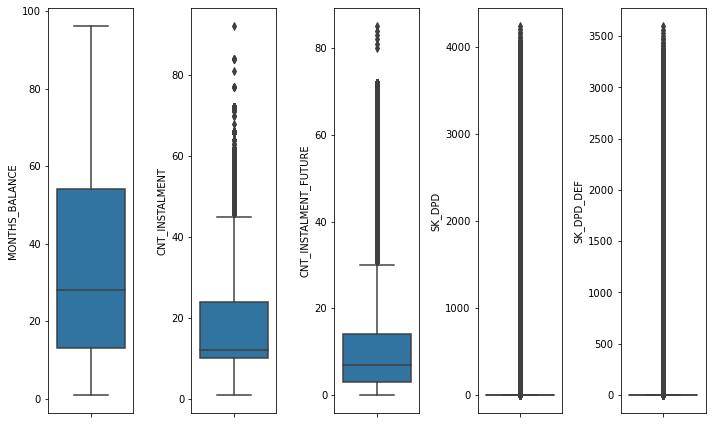

In [91]:
f,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize = (10,6))
sns.boxplot(y='MONTHS_BALANCE', data=df_POS_CASH_balance_numeric, ax=ax1)
sns.boxplot(y='CNT_INSTALMENT', data=df_POS_CASH_balance_numeric, ax=ax2)
sns.boxplot(y= 'CNT_INSTALMENT_FUTURE', data=df_POS_CASH_balance_numeric, ax=ax3)
sns.boxplot(y='SK_DPD', data=df_POS_CASH_balance_numeric, ax=ax4)
sns.boxplot(y='SK_DPD_DEF', data=df_POS_CASH_balance_numeric, ax=ax5)

plt.tight_layout()



In [92]:
num_POS_CASH_balance_agg = df_POS_CASH_balance_numeric.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'median', 'max', 'min', 'sum', 'std','var']).reset_index()
num_POS_CASH_balance_agg.columns=['POS_CASH_'+'_'.join(col) for col in num_POS_CASH_balance_agg.columns.values]
num_POS_CASH_balance_agg=num_POS_CASH_balance_agg.rename(columns={'POS_CASH_SK_ID_CURR_':'SK_ID_CURR'})
num_POS_CASH_balance_agg.head()

,SK_ID_CURR,POS_CASH_MONTHS_BALANCE_mean,POS_CASH_MONTHS_BALANCE_median,POS_CASH_MONTHS_BALANCE_max,POS_CASH_MONTHS_BALANCE_min,POS_CASH_MONTHS_BALANCE_sum,POS_CASH_MONTHS_BALANCE_std,POS_CASH_MONTHS_BALANCE_var,POS_CASH_CNT_INSTALMENT_mean,POS_CASH_CNT_INSTALMENT_median,...,POS_CASH_SK_DPD_sum,POS_CASH_SK_DPD_std,POS_CASH_SK_DPD_var,POS_CASH_SK_DPD_DEF_mean,POS_CASH_SK_DPD_DEF_median,POS_CASH_SK_DPD_DEF_max,POS_CASH_SK_DPD_DEF_min,POS_CASH_SK_DPD_DEF_sum,POS_CASH_SK_DPD_DEF_std,POS_CASH_SK_DPD_DEF_var
0,100001,72.555556,57.0,96,53,653,20.863312,435.277778,4.000000,4.0,...,7,2.333333,5.444444,0.777778,0.0,7,0,7,2.333333,5.444444
1,100002,10.000000,10.0,19,1,190,5.627314,31.666667,24.000000,24.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
2,100003,43.785714,26.5,77,18,1226,24.640162,607.137566,10.107143,12.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
3,100004,25.500000,25.5,27,24,102,1.290994,1.666667,3.750000,4.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000
4,100005,20.000000,20.0,25,15,220,3.316625,11.000000,11.700000,12.0,...,0,0.000000,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000


In [93]:
POS_CASH_balance_count=df_POS_CASH_balance.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV': 'POS_CASH_previous_POS_CASH_balance_counts'})
POS_CASH_balance_count.head()

,SK_ID_CURR,POS_CASH_previous_POS_CASH_balance_counts
0,100001,9
1,100002,19
2,100003,28
3,100004,4
4,100005,11


### Final POS_CASH_balance

In [94]:
final_POS_CASH_balance=num_POS_CASH_balance_agg.merge(cat_count_POS, how='outer', on='SK_ID_CURR').merge(mode_POS_CASH_balance, how='outer', on='SK_ID_CURR')
final_POS_CASH_balance.head()

,SK_ID_CURR,POS_CASH_MONTHS_BALANCE_mean,POS_CASH_MONTHS_BALANCE_median,POS_CASH_MONTHS_BALANCE_max,POS_CASH_MONTHS_BALANCE_min,POS_CASH_MONTHS_BALANCE_sum,POS_CASH_MONTHS_BALANCE_std,POS_CASH_MONTHS_BALANCE_var,POS_CASH_CNT_INSTALMENT_mean,POS_CASH_CNT_INSTALMENT_median,...,POS_CASH_SK_DPD_DEF_var,count_POS_NAME_CONTRACT_STATUS_type_Active,count_POS_NAME_CONTRACT_STATUS_type_Completed,count_POS_NAME_CONTRACT_STATUS_type_Signed,count_POS_NAME_CONTRACT_STATUS_type_Approved,count_POS_NAME_CONTRACT_STATUS_type_Returned to the store,count_POS_NAME_CONTRACT_STATUS_type_Demand,count_POS_NAME_CONTRACT_STATUS_type_Canceled,count_POS_NAME_CONTRACT_STATUS_type_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS
0,100001,72.555556,57.0,96,53,653,20.863312,435.277778,4.000000,4.0,...,5.444444,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,Active
1,100002,10.000000,10.0,19,1,190,5.627314,31.666667,24.000000,24.0,...,0.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Active
2,100003,43.785714,26.5,77,18,1226,24.640162,607.137566,10.107143,12.0,...,0.000000,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,Active
3,100004,25.500000,25.5,27,24,102,1.290994,1.666667,3.750000,4.0,...,0.000000,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Active
4,100005,20.000000,20.0,25,15,220,3.316625,11.000000,11.700000,12.0,...,0.000000,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Active


## 7) Previous application

### 7.1 Data Overview
This is previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

In [95]:
df_previous_application=pd.read_csv('Original_data/previous_application.csv')
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### 7.2 Categorical Features

In [96]:
df_previous_application.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')

In [97]:
selected_features=['NAME_CONTRACT_STATUS','NAME_CLIENT_TYPE']

In [98]:
df_previous_application['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [99]:
df_previous_application['NAME_CONTRACT_STATUS'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [100]:
df_previous_application['NAME_CONTRACT_STATUS']=df_previous_application['NAME_CONTRACT_STATUS'].replace(to_replace=['Refused', 'Canceled', 'Unused offer'],value='Not Approved')

In [101]:
df_previous_application['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [102]:
df_previous_application['NAME_CLIENT_TYPE']=df_previous_application['NAME_CLIENT_TYPE'].replace(to_replace=['Refreshed','XNA'],value='Other')

In [103]:
def cat_count(df,group_by):
  """ takes a dataframe and calculates counts values of the categorial columns specified by the group_by column """
  d={}
  for column in selected_features:
      cat_types=df[column].unique().tolist()
      for cat_type in cat_types:
        d["df_{}".format(cat_type)] = df[df[column]==cat_type].groupby(group_by, as_index=False)[column].count()
        d['df_{}'.format(cat_type)].rename(columns={'{}'.format(column):'count_{}_{}_type_{}'.format('previous_app',column,cat_type)},inplace=True)
      dff=pd.concat([d[i].set_index('SK_ID_CURR') for i in d.keys()], axis=1).fillna(value=0).reset_index()
  return dff 

cat_count=cat_count(df=df_previous_application, group_by='SK_ID_CURR')
cat_count.head()

,SK_ID_CURR,count_previous_app_NAME_CONTRACT_STATUS_type_Approved,count_previous_app_NAME_CONTRACT_STATUS_type_Not Approved,count_previous_app_NAME_CLIENT_TYPE_type_Repeater,count_previous_app_NAME_CLIENT_TYPE_type_New,count_previous_app_NAME_CLIENT_TYPE_type_Other
0,100001,1.0,0.0,0.0,0.0,1.0
1,100002,1.0,0.0,0.0,1.0,0.0
2,100003,3.0,0.0,1.0,0.0,2.0
3,100004,1.0,0.0,0.0,1.0,0.0
4,100005,1.0,1.0,1.0,1.0,0.0


In [104]:
cat_mode=df_previous_application.groupby('SK_ID_CURR', as_index=False,)[selected_features].agg(lambda x: scipy.stats.mode(x)[0]).add_prefix('most_frequent_previous_app_')
cat_mode.rename(columns={'most_frequent_previous_app_SK_ID_CURR':'SK_ID_CURR'}, inplace=True)
cat_mode.head()

,SK_ID_CURR,most_frequent_previous_app_NAME_CONTRACT_STATUS,most_frequent_previous_app_NAME_CLIENT_TYPE
0,100001,Approved,Other
1,100002,Approved,New
2,100003,Approved,Other
3,100004,Approved,New
4,100005,Approved,New


### 7.3 Numerical Features

In [105]:
previous_application_count = df_previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV': 'previous_application_counts'})
previous_application_count.head()

,SK_ID_CURR,previous_application_counts
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


### Final Previous Application

In [106]:
final_previous_application=previous_application_count.merge(cat_count, how='outer', on='SK_ID_CURR').merge(cat_mode, how='outer', on='SK_ID_CURR')
final_previous_application.head()

,SK_ID_CURR,previous_application_counts,count_previous_app_NAME_CONTRACT_STATUS_type_Approved,count_previous_app_NAME_CONTRACT_STATUS_type_Not Approved,count_previous_app_NAME_CLIENT_TYPE_type_Repeater,count_previous_app_NAME_CLIENT_TYPE_type_New,count_previous_app_NAME_CLIENT_TYPE_type_Other,most_frequent_previous_app_NAME_CONTRACT_STATUS,most_frequent_previous_app_NAME_CLIENT_TYPE
0,100001,1,1.0,0.0,0.0,0.0,1.0,Approved,Other
1,100002,1,1.0,0.0,0.0,1.0,0.0,Approved,New
2,100003,3,3.0,0.0,1.0,0.0,2.0,Approved,Other
3,100004,1,1.0,0.0,0.0,1.0,0.0,Approved,New
4,100005,2,1.0,1.0,1.0,1.0,0.0,Approved,New


In [109]:
df11=pd.read_csv('Final_data/df_application_train_without_null_without_dummies.csv')
df11.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 122 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307216 non-null  int64  
 1   TARGET                        307216 non-null  int64  
 2   NAME_CONTRACT_TYPE            307216 non-null  object 
 3   CODE_GENDER                   307216 non-null  object 
 4   FLAG_OWN_CAR                  307216 non-null  object 
 5   FLAG_OWN_REALTY               307216 non-null  object 
 6   CNT_CHILDREN                  307216 non-null  object 
 7   AMT_INCOME_TOTAL              307216 non-null  float64
 8   AMT_CREDIT                    307216 non-null  float64
 9   AMT_ANNUITY                   307216 non-null  float64
 10  AMT_GOODS_PRICE               307216 non-null  float64
 11  NAME_TYPE_SUITE               307216 non-null  object 
 12  NAME_INCOME_TYPE              307216 non-nu

In [114]:
df12=pd.read_csv('Final_data/df_application_train_with_null_without_dummies.csv')
df12.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 122 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307216 non-null  int64  
 1   TARGET                        307216 non-null  int64  
 2   NAME_CONTRACT_TYPE            307216 non-null  object 
 3   CODE_GENDER                   307216 non-null  object 
 4   FLAG_OWN_CAR                  307216 non-null  object 
 5   FLAG_OWN_REALTY               307216 non-null  object 
 6   CNT_CHILDREN                  307216 non-null  object 
 7   AMT_INCOME_TOTAL              307216 non-null  float64
 8   AMT_CREDIT                    307216 non-null  float64
 9   AMT_ANNUITY                   307216 non-null  float64
 10  AMT_GOODS_PRICE               307216 non-null  float64
 11  NAME_TYPE_SUITE               306202 non-null  object 
 12  NAME_INCOME_TYPE              307216 non-nu

## Final cleaned df

In [115]:
#cleaned_df_application_train=pd.read_csv('Final_data/cleaned_df_application_train.csv')
df=df12.merge(final_bureau, how='left', on='SK_ID_CURR').merge(final_bureau_balance, how='left', on='SK_ID_CURR').merge(final_cc_balance, how='left', on='SK_ID_CURR').merge(final_installment_payments, how='left', on='SK_ID_CURR').merge(final_POS_CASH_balance, how='left', on='SK_ID_CURR').merge(final_previous_application, how='left', on='SK_ID_CURR')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,count_POS_NAME_CONTRACT_STATUS_type_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS,previous_application_counts,count_previous_app_NAME_CONTRACT_STATUS_type_Approved,count_previous_app_NAME_CONTRACT_STATUS_type_Not Approved,count_previous_app_NAME_CLIENT_TYPE_type_Repeater,count_previous_app_NAME_CLIENT_TYPE_type_New,count_previous_app_NAME_CLIENT_TYPE_type_Other,most_frequent_previous_app_NAME_CONTRACT_STATUS,most_frequent_previous_app_NAME_CLIENT_TYPE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,Active,1.0,1.0,0.0,0.0,1.0,0.0,Approved,New
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,Active,3.0,3.0,0.0,1.0,0.0,2.0,Approved,Other
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,Active,1.0,1.0,0.0,0.0,1.0,0.0,Approved,New
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,Active,9.0,5.0,4.0,8.0,1.0,0.0,Approved,Repeater
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,Active,6.0,6.0,0.0,5.0,1.0,0.0,Approved,Repeater


In [111]:
#without null without dummies
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307216 entries, 0 to 307215
Data columns (total 485 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   SK_ID_CURR                                                   307216 non-null  int64  
 1   TARGET                                                       307216 non-null  int64  
 2   NAME_CONTRACT_TYPE                                           307216 non-null  object 
 3   CODE_GENDER                                                  307216 non-null  object 
 4   FLAG_OWN_CAR                                                 307216 non-null  object 
 5   FLAG_OWN_REALTY                                              307216 non-null  object 
 6   CNT_CHILDREN                                                 307216 non-null  object 
 7   AMT_INCOME_TOTAL                                             307

In [116]:
#with null without dummies
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307216 entries, 0 to 307215
Data columns (total 485 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   SK_ID_CURR                                                   307216 non-null  int64  
 1   TARGET                                                       307216 non-null  int64  
 2   NAME_CONTRACT_TYPE                                           307216 non-null  object 
 3   CODE_GENDER                                                  307216 non-null  object 
 4   FLAG_OWN_CAR                                                 307216 non-null  object 
 5   FLAG_OWN_REALTY                                              307216 non-null  object 
 6   CNT_CHILDREN                                                 307216 non-null  object 
 7   AMT_INCOME_TOTAL                                             307

In [112]:
df.to_csv('Final_data/cleaned_df_without_null_without_dummies.csv', index=False)

In [117]:
df.to_csv('Final_data/cleaned_df_with_null_without_dummies.csv', index=False)